# Santiago De Chile Delays

#### Required Packages
First we must all the required packages for completing the work

In [2]:
!pip install --upgrade pip --user
!pip install -r ../requirements.txt --user

#### Importing required tools
Let's import all the tools we need

In [145]:
# Data Analysis
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# Extracting Geological information
from geopy.geocoders import Nominatim
from geopy.distance import great_circle as GRC
# Pre processing
from sklearn import preprocessing
# Data prep
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
# ML Model development
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# Model evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score,roc_auc_score, roc_curve, precision_score, recall_score, plot_confusion_matrix
from scikitplot.metrics import plot_roc_curve as auc_roc
# Model optimization
from sklearn.model_selection import GridSearchCV
np.random.seed(10)

## Step 1: Reviewing the Dataset
Let's first go over the provided data and see what valuable insights we can find.

We begin by loading the dataframe with pandas library and viewing the it's head.

In [163]:
df = pd.read_csv('../data/dataset_SCL.csv')
df.head()

C:\Users\kevin\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3433: DtypeWarning: Columns (1,6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami


For a better understanding of the different labels below are the information for each column:

* **Fecha-I :** Scheduled date and time of the flight.
* **Vlo-I :** Scheduled flight number.
* **Ori-I :** Programmed origin city code.
* **Des-I :** Programmed destination city code.
* **Emp-I :** Scheduled flight airline code.
* **Fecha-O :** Date and time of flight operation.
* **Vlo-O :** Flight operation number of the flight.
* **Ori-O :** Operation origin city code
* **Des-O :** Operation destination city code.
* **Emp-O :** Airline code of the operated flight.
* **DIA:** Day of the month of flight operation.
* **MES :** Number of the month of operation of the flight.
* **AÑO :** Year of flight operation.
* **DIANOM :** Day of the week of flight operation.
* **TIPOVUELO :** Type of flight, I =International, N =National.
* **OPERA :** Name of the airline that operates.
* **SIGLAORI :** Name city of origin.
* **SIGLADES :** Destination city name.

The dataframe has exactly 18 columns related to each flight.  Below is a list of my findings from my initial analysis with some assumptions that I may be able to consider:

1) The most important information here is the flight scheduled/operation time (Fecha-I/O) as it includes when the aircraft was scheduled to operate and when it actually operated.
2) The day of the week (DIANOM) is also important because as a fellow traveller myself I'd like to fly out on a weekend as I would not loose any extra days of work.  Some days also generally tend to be more affordable to fly out than other days.
3) There's the Day (DIA), Month (MES) and Year (AÑO) listed in three seperate columns so it may not be necassary to have them listed again in both **Fecha-I** and **Fecha-O**.  
4) All codes for the flight number (Vlo), origin city (Ori), destination city (Des) and scheduled flight airline (Emp) may be duplicate values for the Programmed (**-I**) and the Operation (**-O**).
5) The **name** for the airline that operates, city of origin and destination city may not be necessary since the code for each are already given.
6) This data also shows me that we are working with unlabeled data so our approach would require unsupervised learning, on the other hand we can also create our own labels.

Let's look into these variables further by listing them out.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68206 entries, 0 to 68205
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Fecha-I    68206 non-null  object
 1   Vlo-I      68206 non-null  object
 2   Ori-I      68206 non-null  object
 3   Des-I      68206 non-null  object
 4   Emp-I      68206 non-null  object
 5   Fecha-O    68206 non-null  object
 6   Vlo-O      68205 non-null  object
 7   Ori-O      68206 non-null  object
 8   Des-O      68206 non-null  object
 9   Emp-O      68206 non-null  object
 10  DIA        68206 non-null  int64 
 11  MES        68206 non-null  int64 
 12  AÑO        68206 non-null  int64 
 13  DIANOM     68206 non-null  object
 14  TIPOVUELO  68206 non-null  object
 15  OPERA      68206 non-null  object
 16  SIGLAORI   68206 non-null  object
 17  SIGLADES   68206 non-null  object
dtypes: int64(3), object(15)
memory usage: 9.4+ MB


There are exactly 68206 number of entries (flights), majority are object types while only the day, month and year are integer types. I want to check if there are any null values.

In [6]:
df.isnull().sum()

Fecha-I      0
Vlo-I        0
Ori-I        0
Des-I        0
Emp-I        0
Fecha-O      0
Vlo-O        1
Ori-O        0
Des-O        0
Emp-O        0
DIA          0
MES          0
AÑO          0
DIANOM       0
TIPOVUELO    0
OPERA        0
SIGLAORI     0
SIGLADES     0
dtype: int64

There is only one null value that is present and it's for the Flight Operation code.  Now I want to look at the number of unique values for each label.

In [7]:
df.nunique()

Fecha-I      53252
Vlo-I          750
Ori-I            1
Des-I           64
Emp-I           30
Fecha-O      62774
Vlo-O          866
Ori-O            1
Des-O           63
Emp-O           32
DIA             31
MES             12
AÑO              2
DIANOM           7
TIPOVUELO        2
OPERA           23
SIGLAORI         1
SIGLADES        62
dtype: int64

So I found that my assumtions may not be true as there are more unique values than others.  The destination code don't also match with the destination city code, this could possibly be because the flight might have landed in a different airport with a different destinaiton code? 

## Step 2: Exploratary Data Analysis for the Flight delay prediction

Now that I know what I am working with, I'd like to perform some exploratory data analysis to gain a better understanding of the independent variables in the dataset and their relationship.

There are other things to consider, for example **Vlo-I** and **Vlo-O** was assumed to have identical values based on previous analysis but the number of unique values are not matching, and I found one null value for **Vlo-O**.  Let's investigate this.

      Vlo-I  Vlo-O
6018   4501   1001
6020   4501   1001
6022   4501   1003
6023   4501   1001
6025   4501   1001
...     ...    ...
65532   265  265.0
65533   265  265.0
65534   265  265.0
65535   265  265.0
68068   110   33.0

[1850 rows x 2 columns]
Number of Unique values for flight number codes:
Vlo-I    1850
Vlo-O    1849
dtype: int64

Number of equal values for flight number codes:
Vlo-I    66356
Vlo-O    66356
dtype: int64


Text(0.5, 1.0, 'Comparison between matched and unmatched codes for Vlo-I and Vlo-O')

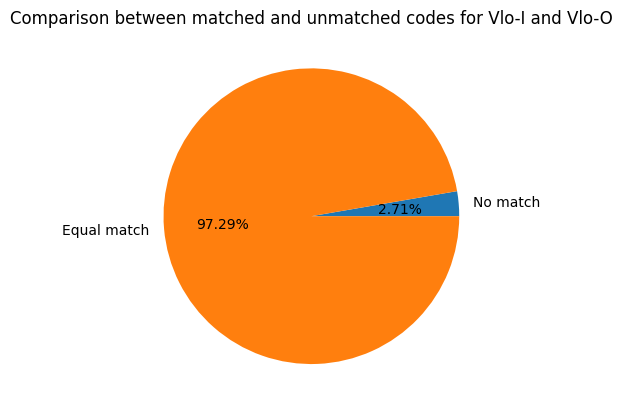

In [177]:
df_vlo = df[['Vlo-I', 'Vlo-O']]

df_vlo_unique = df_vlo[df_vlo['Vlo-I'] != df_vlo['Vlo-O']]
df_vlo_equal = df_vlo[df_vlo['Vlo-I'] == df_vlo['Vlo-O']]
unique_vlo = df_vlo_unique.count()
equal_vlo = df_vlo_equal.count()
print(df_vlo_unique)
print('Number of Unique values for flight number codes:\n{}\n\nNumber of equal values for flight number codes:\n{}'.format(unique_vlo, equal_vlo))

comp_vlo = [unique_vlo['Vlo-I'], equal_vlo['Vlo-I']]
plt.pie(comp_vlo, labels=['No match', 'Equal match'], autopct='%1.2f%%')
plt.title('Comparison between matched and unmatched codes for Vlo-I and Vlo-O')

From the above analysis, there are about 66356 equaled values among both the operation flight number and scheduled flight number and about 1850 samples (about 2% of dataset) of unequaled values.  I want to beleive that the schduled flight may not be the same as the operated flight which is why we have this small percentage of differences, however we can also see that some of the values are the same it just includes a decimal point. 

Before I make any assumptions I want to clear out any other duplicates such as the float and integer numbers that are the same.

C:\Users\kevin\AppData\Local\Temp\ipykernel_15368\661057280.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vlo['Vlo-I'] = df_vlo['Vlo-I'].apply(lambda x: pd.to_numeric(x, errors='coerce'))


Number of Unique values for flight number codes:
Vlo-I    116
Vlo-O    104
dtype: int64

Number of equal values for flight number codes:
Vlo-I    68085
Vlo-O    68085
dtype: int64


C:\Users\kevin\AppData\Local\Temp\ipykernel_15368\661057280.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vlo['Vlo-O'] = df_vlo['Vlo-O'].apply(lambda x: pd.to_numeric(x, errors='coerce'))


Text(0.5, 1.0, 'Comparison between matched and unmatched codes for Vlo-I and Vlo-O')

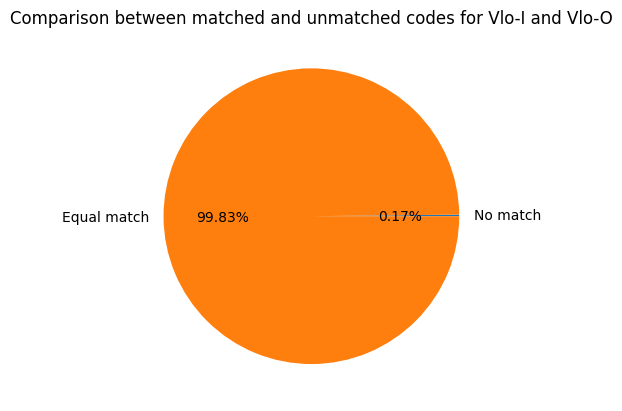

In [179]:
df_vlo['Vlo-I'] = df_vlo['Vlo-I'].apply(lambda x: pd.to_numeric(x, errors='coerce'))
df_vlo['Vlo-O'] = df_vlo['Vlo-O'].apply(lambda x: pd.to_numeric(x, errors='coerce'))

df_vlo_unique = df_vlo[df_vlo['Vlo-I'] != df_vlo['Vlo-O']]
df_vlo_equal = df_vlo[df_vlo['Vlo-I'] == df_vlo['Vlo-O']]
unique_vlo = df_vlo_unique.count()
equal_vlo = df_vlo_equal.count()
print('Number of Unique values for flight number codes:\n{}\n\nNumber of equal values for flight number codes:\n{}'.format(unique_vlo, equal_vlo))

comp_vlo = [unique_vlo['Vlo-I'], equal_vlo['Vlo-I']]
plt.pie(comp_vlo, labels=['No match', 'Equal match'], autopct='%1.2f%%')
plt.title('Comparison between matched and unmatched codes for Vlo-I and Vlo-O')

Since we've done deeper investigation we can see that theres a higher match than unequal matches between the scheduled and operating flight numbers. So now I will **assume** that the scheduled flight number is the same as the flight operation number so I will disregard Vlo-O in the future.

Let's take a look at the type of flights to occur.

<AxesSubplot:xlabel='TIPOVUELO', ylabel='count'>

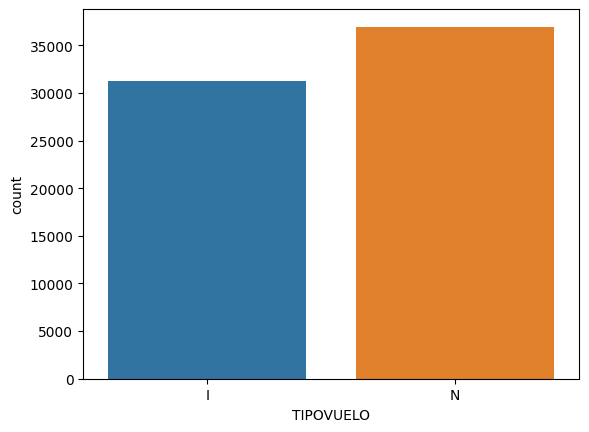

In [9]:
sns.countplot(x='TIPOVUELO', data=df)

So it seems that in 2017 there were more national/domestic flights than international flights.  Let's explore the different destinations and it's codes (scheduled/operation)

<AxesSubplot:xlabel='count', ylabel='Des-O'>

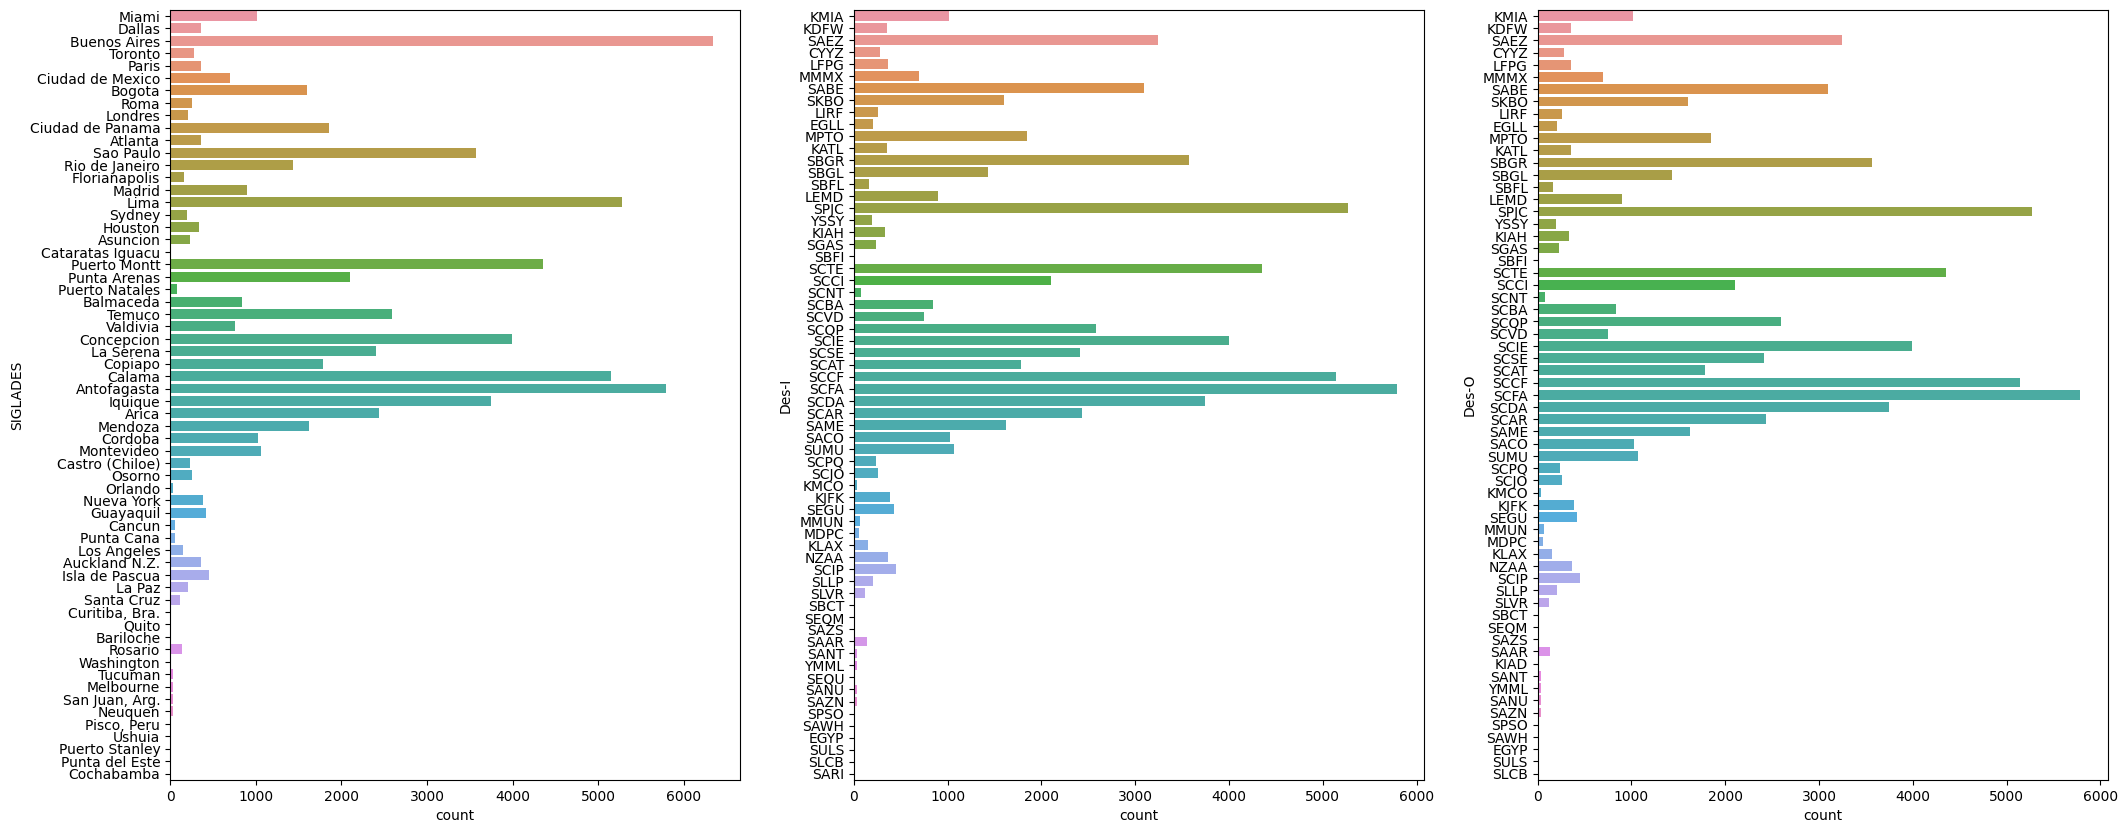

In [10]:
plt.figure(figsize=(25,10))
plt.subplot(1, 3, 1)
sns.countplot(y='SIGLADES', data=df)
plt.subplot(1, 3, 2)
sns.countplot(y='Des-I', data=df)
plt.subplot(1, 3, 3)
sns.countplot(y='Des-O', data=df)

Based on the different destinations and the type of flight (International or National) the data seems to match as the majority of city destinations are in Chile.

The above plots have a similar pattern so this tells me that the destination city coincides with the city code for both the scheduled and operational.  Let's see if there are any unmatched city code values.

Number of Unique values for destination codes:
Des-I    28
Des-O    28
dtype: int64

Number of equal values for destination codes:
Des-I    68178
Des-O    68178
dtype: int64


Text(0.5, 1.0, 'Comparison between matched and unmatched codes for Des-I and Des-O')

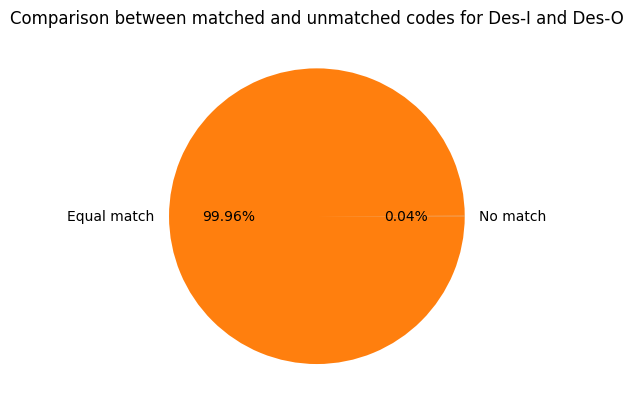

In [11]:
df_des = df[['Des-I', 'Des-O']]
df_des_unique = df_des[df_des['Des-I'] != df_des['Des-O']]
df_des_equal = df_des[df_des['Des-I'] == df_des['Des-O']]
unique_des = df_des_unique.count()
equal_des = df_des_equal.count()
print('Number of Unique values for destination codes:\n{}\n\nNumber of equal values for destination codes:\n{}'.format(unique_des, equal_des))

comp_des = [unique_des['Des-I'], equal_des['Des-I']]
plt.pie(comp_des, labels=['No match', 'Equal match'], autopct='%1.2f%%')
plt.title('Comparison between matched and unmatched codes for Des-I and Des-O')

The above analysis shows me that there are exactly 68206 Identical samples for the both the **Des-I** and **Des-O** data, and only 28 which shows me that this data might have been mislabelled which is about 0.04% of the overall data.  Since very little values match, **I will assume** that the programmed destination city code (Des-I) is the same as the Operation Destination City code (Des-O).

Let's explore the operation airline name versus it's airline code (scheduled/operational)

<AxesSubplot:xlabel='count', ylabel='Emp-O'>

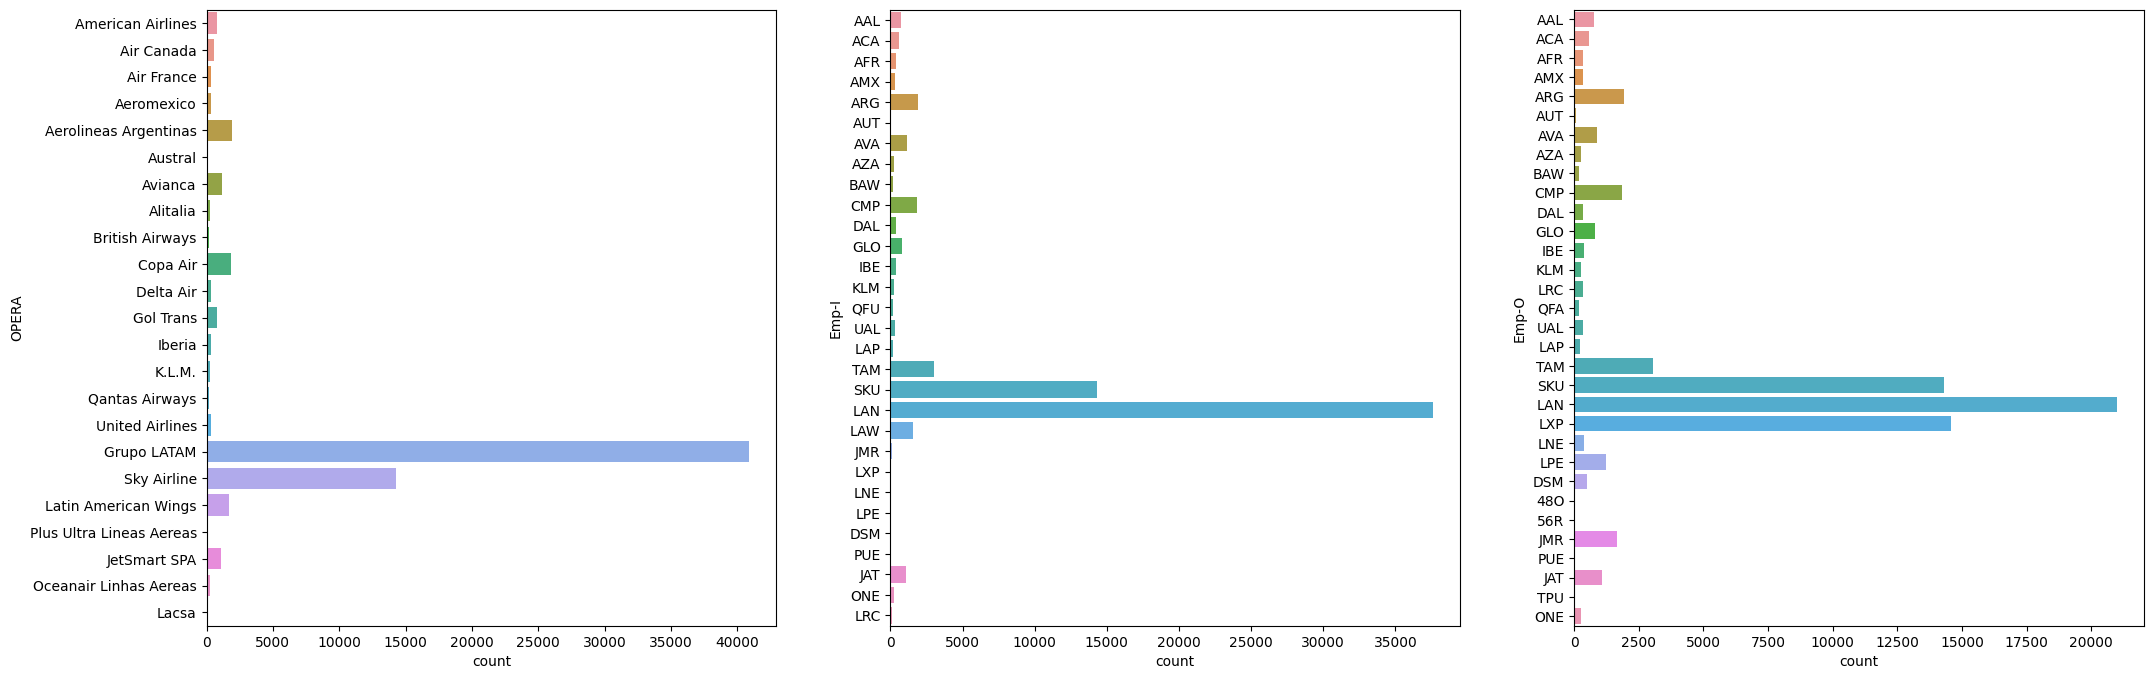

In [12]:
plt.figure(figsize=(25,8))
plt.subplot(1, 3, 1)
sns.countplot(y='OPERA', data=df)
plt.subplot(1, 3, 2)
sns.countplot(y='Emp-I', data=df)
plt.subplot(1, 3, 3)
sns.countplot(y='Emp-O', data=df)

I would assume that the three plot would look very similar but that is not the case so let's explore the number of unqual matches between the Emp-I and Emp-O.

Number of Unique values for airline codes:
Emp-I    18669
Emp-O    18669
dtype: int64

Number of equal values for airline codes: 
Emp-I    49537
Emp-O    49537
dtype: int64


Text(0.5, 1.0, 'Comparison between matched and unmatched codes for Emp-I and Emp-O')

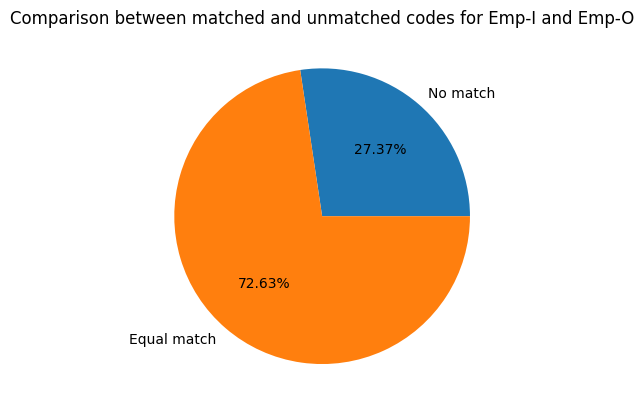

In [13]:
df_emp = df[['Emp-I', 'Emp-O']]
df_emp_unique = df_emp[df_emp['Emp-I'] != df_emp['Emp-O']]
df_emp_equal = df_emp[df_emp['Emp-I'] == df_emp['Emp-O']]
unique_emp = df_emp_unique.count()
equal_emp = df_emp_equal.count()
print('Number of Unique values for airline codes:\n{}\n\nNumber of equal values for airline codes: \n{}'.format(unique_emp, equal_emp))

comp_emp = [unique_emp['Emp-I'], equal_emp['Emp-I']]
plt.pie(comp_emp, labels=['No match', 'Equal match'], autopct='%1.2f%%')
plt.title('Comparison between matched and unmatched codes for Emp-I and Emp-O')

The above data shows me that the airline code of operated flight may not be correlate to the scheduled flight airline code.  So I will not make any assumptions, however I may want to train two seperate models with and without Emp-O feature.

Text(0.5, 1.0, 'Scheduled datetime vs Operational Date time')

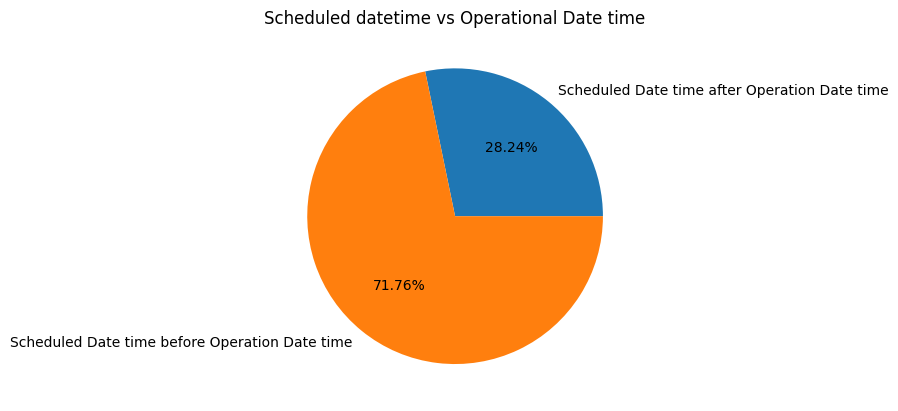

In [14]:
date_i = pd.to_datetime(df['Fecha-I'], format='%Y-%m-%d %H:%M:%S')
date_o = pd.to_datetime(df['Fecha-O'], format='%Y-%m-%d %H:%M:%S')

ahead_sched = (date_i>date_o).sum()
norm_sched = (date_i<date_o).sum()

plt.pie([ahead_sched, norm_sched], labels=['Scheduled Date time after Operation Date time', 'Scheduled Date time before Operation Date time'], autopct='%1.2f%%')
plt.title('Scheduled datetime vs Operational Date time')

The above analysis shows me that some of the Flights has a Flight operation before the scheduled date and time of flight.  **I will make the assumption** that this could mean that the flight operated early and left before the scheduled time.

In [15]:
df_date = df[df['AÑO']==2018]
df_date

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
66918,2017-12-31 23:55:00,602,SCEL,KLAX,LAN,2018-01-01 00:02:00,602.0,SCEL,KLAX,LAN,1,1,2018,Lunes,I,Grupo LATAM,Santiago,Los Angeles
66947,2017-12-31 23:40:00,622,SCEL,MMMX,LAN,2018-01-01 00:12:00,622.0,SCEL,MMMX,LAN,1,1,2018,Lunes,I,Grupo LATAM,Santiago,Ciudad de Mexico


These two samples are unique ones as the scheduled flight time was before the new year and the operation time went onto the next year.  These two samples will need to be further processed later on to obtain accurate results.  This also shows me that the Day, Month and Year columns coincide with the Fecha-O column which is important to consider.

Let's observe the day, day of week, month and type of flight.

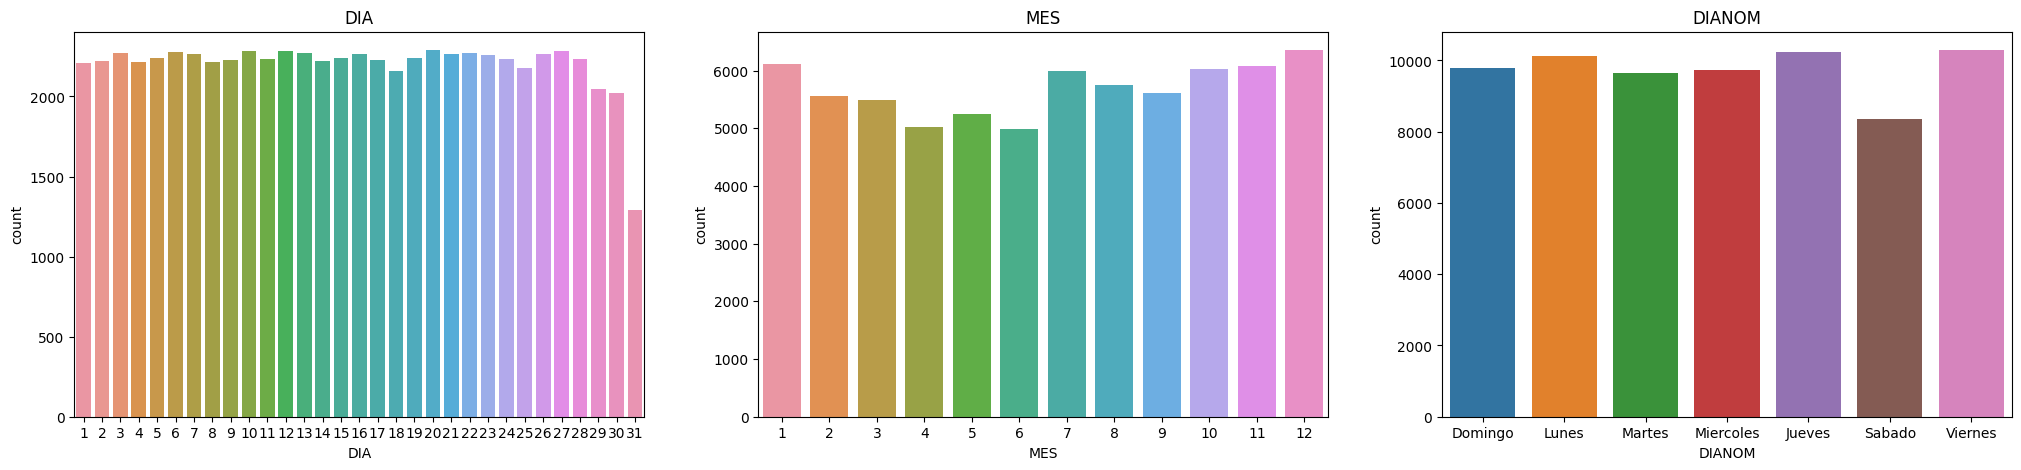

In [180]:
cols = ['DIA', 'MES', 'DIANOM']
plt.figure(figsize=(25,5))

for i, col in enumerate(cols):
    ax = plt.subplot(1, len(cols), i+1)
    sns.countplot(x=col, data=df)
    ax.set_title('{}'.format(col))


A few interesting observations can be made here:

1) The number of flights are consistent throughout the month, except when reaching near the end of the month the number of flight drops.
2) The frequency of flights drops between April and June.  The months with high flight frequency seems to be during January, July and October-December.
3) Saturdays tends to be days where travel isn't so frequent, which would make sense since normally when I search for flights Saturdays are always the most expensive.

In [ ]:
def city_country_split(city):
    siglades = city.split(',')
    return siglades[0]

ori_des = df[['SIGLAORI', 'SIGLADES']]
ori_des['SIGLADES'] = ori_des.apply(lambda x: city_country_split(x['SIGLADES']), axis=1)
ori_des_unique = ori_des.drop_duplicates()

def get_coordinates(city):
    location = geolocator.geocode(city)
    if location is None:
        print(city)
    return (location.latitude, location.longitude)


geolocator = Nominatim(user_agent="locate_city")

ori_des_unique['SIGLADES'] = ori_des_unique['SIGLADES'].map(get_coordinates)
ori_des_unique['distance_mile'] = ori_des_unique.apply(lambda x: (GRC(x['SIGLAORI'], x['SIGLADES'])).mile, axis=1)
ori_des_unique

I wanted to extracted the distance between the origin and destination but Nominatim takes 1 second per operation and then I tried to extract unique origin-destination flights but then the destination has other values such as city and does not include full country name.

## Step 3: Feature extraction/Feature Engineering for Delay prediction

This step will have the following data preprocessing to generate new data for delay prediction.  The dollowing new data are as follows:

1) **high_season**: If Fecha-I is between Dec-15 and Mar-3, or Jul-15 and Jul-31, or Sep-11 and Sep-30 will have a value of 1 and 0 otherwise.
2) **min_diff**: Difference in minutes between Fecha-O and Fech-I.
3) **delay_15**: if min_diff > 15 then give value 1, else 0.
4) **period_day**: morning (between 5:00 and 11:59), afternoon (between 12:00 and 18:59), and night (between 19:00 and 4:59), based on Fecha-I.

These four steps all focus on the Fecha-I and Fecha-O, so I will begin with processing the Fecha-I samples.  A few things to consider when dealing with this data:

* It is a string in the format of 'yyyy-mm-dd hh:mm:ss'
* Time is 24-hour clock which makes it simple to understand and not having to convert from a 12 hour to a 24 hour clock.
* Only conversion that may be required is convert the 24 hour time to minutes or seconds as the seconds for quicker comparison between Fecha-I and Fecha-O.
* If the the operaiton flight followed to the next day then additional procesing is required.

In order to complete my data processing I have to create a few functions to manipulate the data and generate the synthetic data:

* `datetime_split`: splits the string data from fecha-I and Fecha-O to an array of integer and converts the 24 Hour time to seconds.
* `min_diff`: Calculates the time difference between Fecha-O and Fecha-I and converts it to minutes.
* `high_season`: I used a dictionary of lists as a lookup table to categories whether a flight flew during peak seasons.
* `delay_15`: If the time differance is greater than 15 minutes then it is considered as a delayed flight.
* `period_day`: I used another dictionary of lists as a lookup table for disinguishing if flight was scheduled for the morning, afternoon or night.

With this data, I then extracted the Fecha-I and Fecha-O data from the original dataframe and produced the desired synthetic features.

In [239]:
def datetime_split(date_str):
    date_time = date_str.split()
    date_time = date_time[0].split('-') + date_time[1].split(':')
    date_time = [int(x) for x in date_time]
    time_s = [date_time[3]*3600 + date_time[4]*60 + date_time[5]]
    return date_time[:3] + time_s

# Optimized code where I consider month and day of 
def min_diff(date_i, date_o, seconds_in_day = 24*3600):
    schedule_date_sec = date_i[2]*seconds_in_day
    
    if date_i[1] == date_o[1]:
        if date_i[2] == date_o[2]:
            time_diff = date_o[3] - date_i[3]
        elif date_i[2] < date_o[2]:
            time_diff = (schedule_date_sec+ date_o[3]) - ((schedule_date_sec - seconds_in_day) + date_i[3])
        else:
            time_diff = (schedule_date_sec - (seconds_in_day-date_o[3])) - (schedule_date_sec + date_i[3])
    else:
        if date_i[2] > date_o[2]:
            time_diff = (schedule_date_sec+ date_o[3]) - ((schedule_date_sec - seconds_in_day) + date_i[3])
        else:
            time_diff = (schedule_date_sec - (seconds_in_day-date_o[3])) - (schedule_date_sec + date_i[3])
    
    return time_diff/60

def high_season(month, day):
    month_season = {'high': [1, 2], 
                    'low': [4, 5, 6, 8, 10, 11], 
                    'mid': {3: list(range(1,4)), 7: list(range(15,32)), 9: list(range(11,31)), 12: list(range(15,32))}}

    # Checks high and low months
    if month in month_season['high']:
        return 1
    elif month in month_season['low']:
        return 0

    # Checks if day of Month with temporary high/low seasons
    if day in month_season['mid'][month]:
        return 1
    else:
        return 0

def delay_15(time_diff):
    return 1 if time_diff>15 else 0

def period_day(time, sec_in_hour = 3600):
    period_of_day = {'morning': [5*sec_in_hour, 12*sec_in_hour],
                    'afternoon': [12*sec_in_hour, 19*sec_in_hour],
                    'night': [19*sec_in_hour, 5*sec_in_hour]}
    
    if time >= period_of_day['morning'][0] and time < period_of_day['morning'][1]:
        return 'morning'
    elif time >= period_of_day['afternoon'][0] and time < period_of_day['afternoon'][1]:
        return 'afternoon'
    elif time >= period_of_day['night'][0] or time < period_of_day['night'][1]:
        return 'night'

In [240]:
df_fecha_op = df[['Fecha-I', 'Fecha-O']]

df_fecha_arr = df_fecha_op.applymap(datetime_split)
df_fecha_arr['high_season'] = df_fecha_arr.apply(lambda x: high_season(month=x['Fecha-I'][1], day=x['Fecha-I'][2]), axis=1)
df_fecha_arr['min_diff'] = df_fecha_arr.apply(lambda x: min_diff(date_i=x['Fecha-I'], date_o=x['Fecha-O']), axis=1)
df_fecha_arr['delay_15'] = df_fecha_arr.apply(lambda x: delay_15(x['min_diff']), axis=1)
df_fecha_arr['period_day'] = df_fecha_arr.apply(lambda x: period_day(x['Fecha-I'][3]), axis=1)

synthetic_features = df_fecha_arr[['min_diff', 'high_season', 'delay_15', 'period_day']]
synthetic_features.to_csv('../data/synthetic_features.csv', index=False)
synthetic_features.head()

,min_diff,high_season,delay_15,period_day
0,3.0,1,0,night
1,9.0,1,0,night
2,9.0,1,0,night
3,3.0,1,0,night
4,-2.0,1,0,night


I noticed there are negative values in the min_diff, **I will assume** that this indicates that the flight arrived earlier than anticipated.

### Additional Data Analysis with synthetic features

Here I will explore the behaviour of the delay rate across destinations, airline, month of the year, day of the week, season, and type of flight.

I also want to include the scheduled time and operational time in hours as additional features and are named as follow:

* `sched_hour`: Scheduled flight time in minutes.
* `op_hour`: Flight operation time in minutes.


In [323]:
df_syn = pd.read_csv('../data/synthetic_features.csv')

df_new = pd.concat([df, df_syn], axis=1)
df_new['sched_hour'] = df_new.apply(lambda x: ((datetime_split(x['Fecha-I']))[3])/3600, axis=1)
df_new['op_hour'] = df_new.apply(lambda x: ((datetime_split(x['Fecha-O']))[3])/3600, axis=1)
df_new[['sched_hour', 'op_hour']].to_csv('../data/additional_features.csv', index=False)
df_new.head()


,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,...,TIPOVUELO,OPERA,SIGLAORI,SIGLADES,min_diff,high_season,delay_15,period_day,sched_hour,op_hour
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,...,I,American Airlines,Santiago,Miami,3.0,1,0,night,23.5,23.550000
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,...,I,American Airlines,Santiago,Miami,9.0,1,0,night,23.5,23.650000
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,...,I,American Airlines,Santiago,Miami,9.0,1,0,night,23.5,23.650000
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,...,I,American Airlines,Santiago,Miami,3.0,1,0,night,23.5,23.550000
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,...,I,American Airlines,Santiago,Miami,-2.0,1,0,night,23.5,23.466667


Let's first observe the distribution of delays accross all flights.

Text(0.5, 1.0, 'Delay vs On Time Flights')

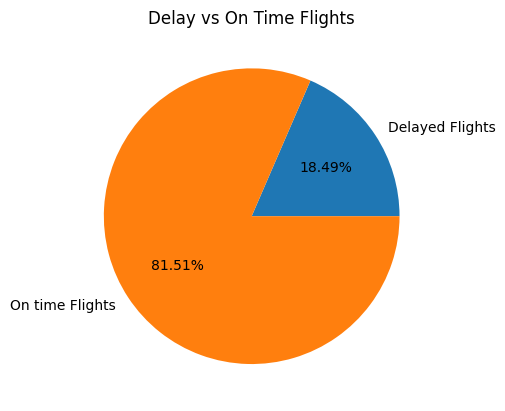

In [277]:
delay = df_new[df_new['delay_15']==1]['delay_15']
no_delay = df_new[df_new['delay_15']==0]['delay_15']

plt.pie([delay.count(), no_delay.count()], labels=['Delayed Flights', 'On time Flights'], autopct='%1.2f%%')
plt.title('Delay vs On Time Flights')

The number of delayed flights are not plenty which is what every airport wants, because honestly... who enjoys delays?  However, this doesn't look good for model training since there is a class imbalance which can lead to an underperforming machine elarning model.

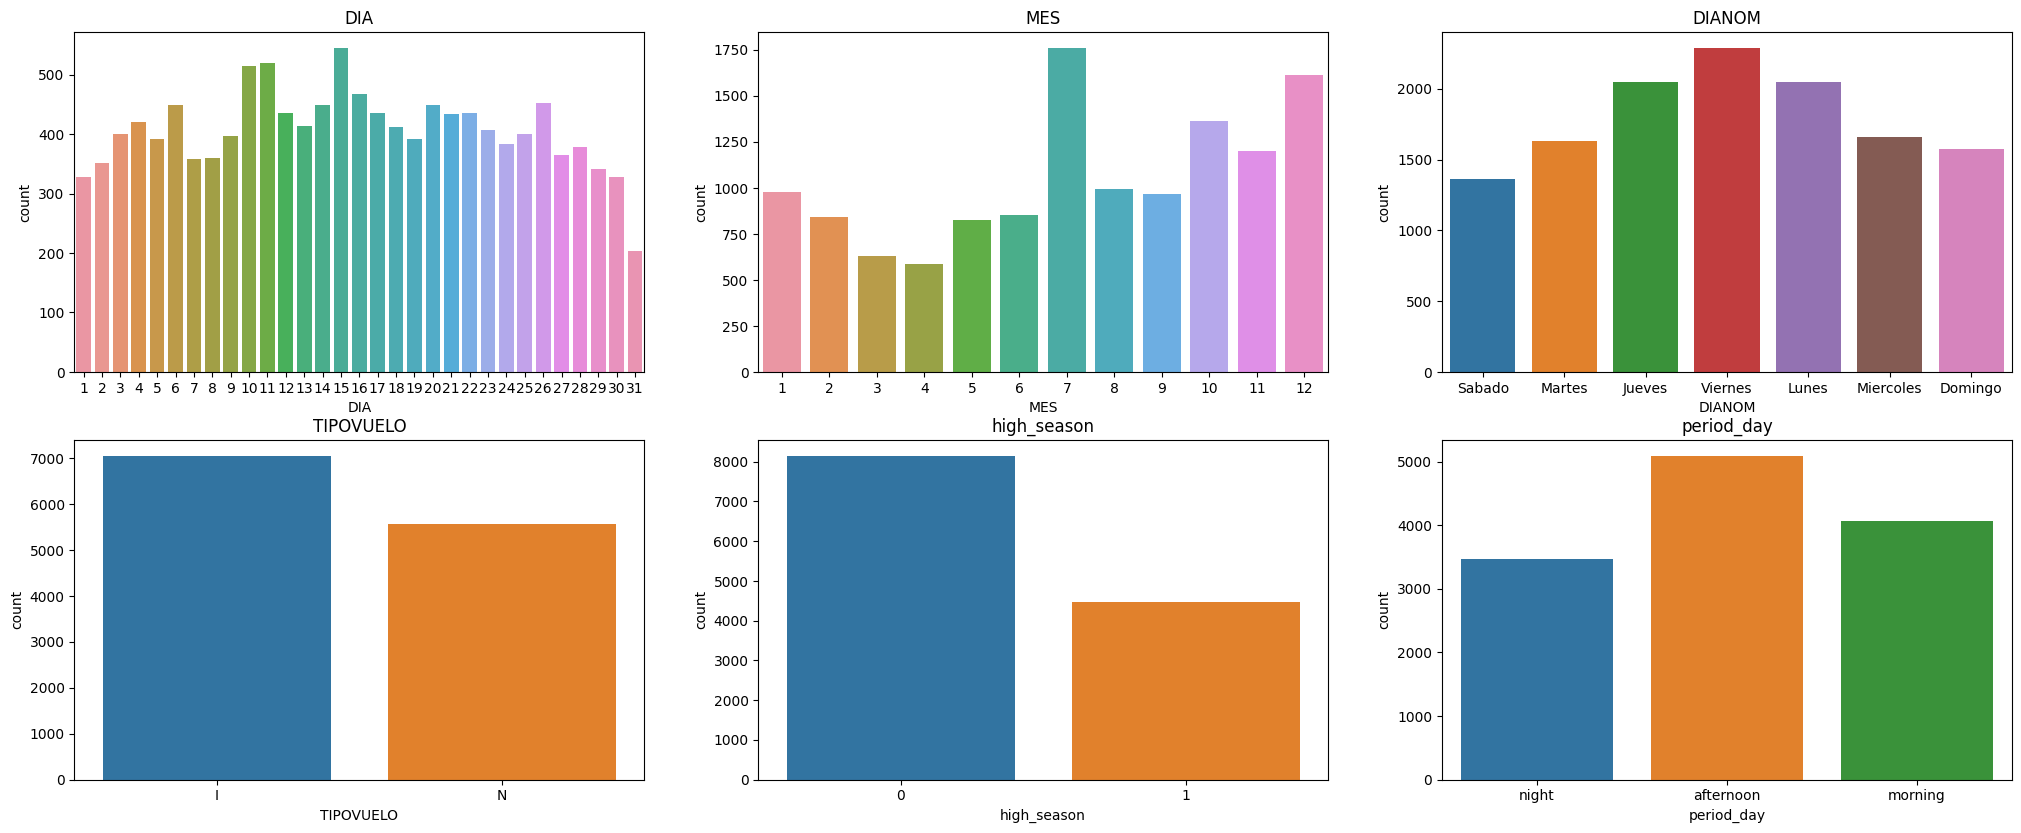

In [278]:
delay = df_new[['DIA', 'MES', 'DIANOM', 'TIPOVUELO', 'Emp-I', 'Emp-O', 'Des-I', 'Des-O', 'OPERA', 'SIGLADES', 'high_season', 'period_day']][df_new['delay_15']==1]
day_month_period = ['DIA', 'MES', 'DIANOM', 'TIPOVUELO', 'high_season', 'period_day']
plt.figure(figsize=(25,15))

for i, col in enumerate(day_month_period):
    ax = plt.subplot(3, int(len(day_month_period)/2), i+1)
    sns.countplot(x=col, data=delay)
    ax.set_title('{}'.format(col))

Few observations to make here based on the delays:
* When the flight is scheduled for the month of July and December there are higher volume of delays, this could be because december is nearing the end of the year so people would love a vacation destination, and July and considering the climate change in Chile during that month it is cold so who wouldn't want to head somewhere warmer?
* Friday experiences the most delays, followed by Monday and Thursday, then Tuesday and Wednesday, and last Saturday and Sunday.  My theory is that travellers all shout T.G.I.F and the flight attendants just can't keep up with them.
* International flights experiences more delays then national/domestic flights.
* Beleive it or not but travelling during high season experiences less delays.
* The number of delays accros the different period of days are greater during the afternoon, then followed by the morning and at night.  If I consider myself in this situation, it would make sense because during afternoon it would coincide during work hours or rush hour so you'd expect travellers to show up late.  The morning, sometimes you don't hear your alarm and can cause delays for everyone.  Night is the best as you can find a ride to the airport easily and you're not rush.

Let's explore the delay behaviour across different airlines.

<AxesSubplot:xlabel='count', ylabel='Emp-O'>

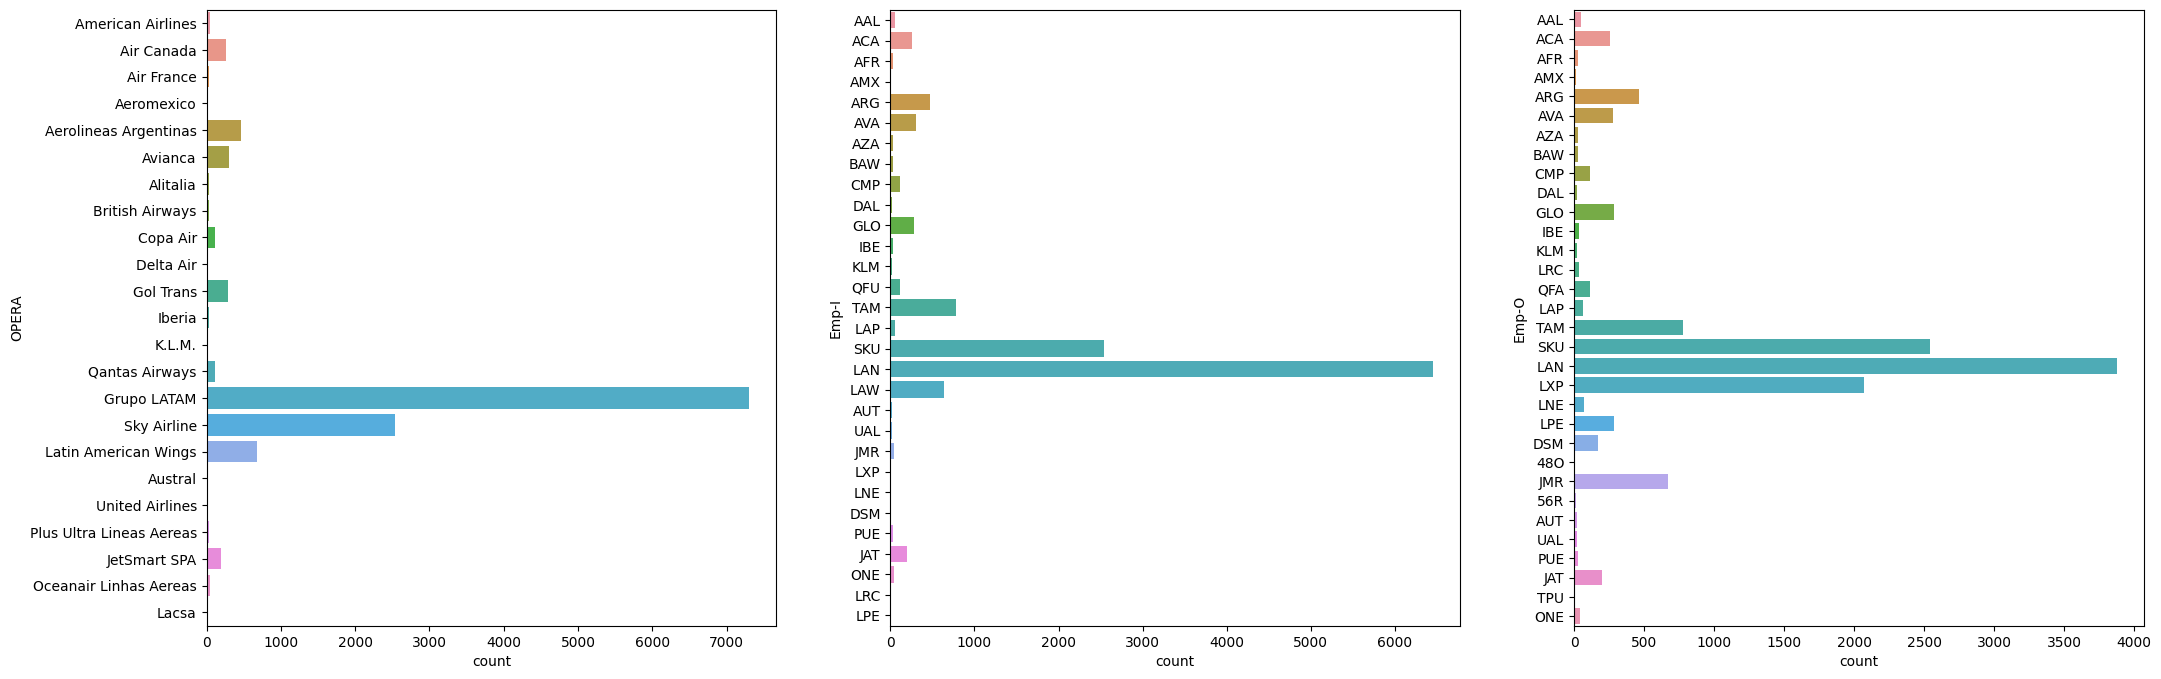

In [279]:
plt.figure(figsize=(25,8))
plt.title("Delay behaviour across airlines (with code comparison)")
plt.subplot(1, 3, 1)
sns.countplot(y='OPERA', data=delay)
plt.subplot(1, 3, 2)
sns.countplot(y='Emp-I', data=delay)
plt.subplot(1, 3, 3)
sns.countplot(y='Emp-O', data=delay)

The above analysis shows that the more flights each airline goes on, the more delays it will encounter.  Let's observe the city destination name and it's delay behaviour.

<AxesSubplot:xlabel='count', ylabel='Des-O'>

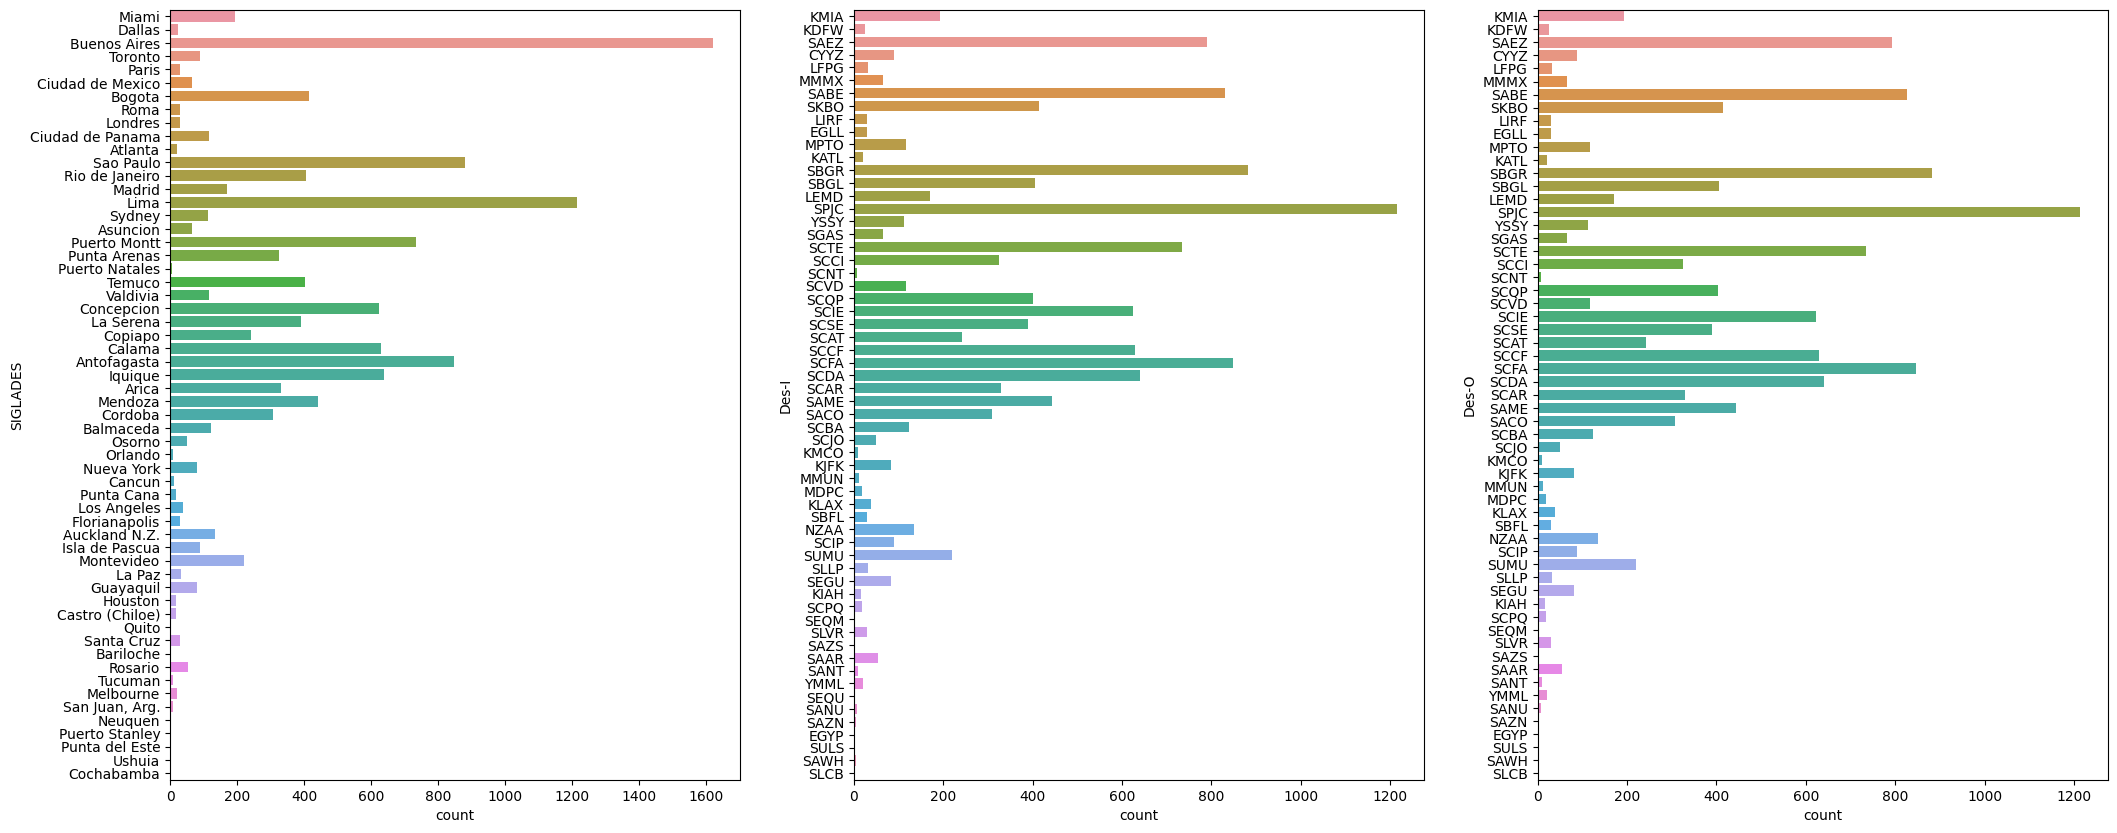

In [280]:
plt.figure(figsize=(25,10))
plt.title("Delay behaviour across airlines (with code comparison)")
plt.subplot(1, 3, 1)
sns.countplot(y='SIGLADES', data=delay)
plt.subplot(1, 3, 2)
sns.countplot(y='Des-I', data=delay)
plt.subplot(1, 3, 3)
sns.countplot(y='Des-O', data=delay)

Again, when comparing to the number of scheduled destinations it will also have a high delay frequency. 

### Data Analysis conclusion:
Based on the above analysis, I will consider the destinations and airlines as it correlates to the rate of delay.  It would be important to consider the type of flight (international/national), in addition with the Month, high/low seasons, period of day and day of week.  Another feature I want to include is the scheduled time and operational time. The reason for picking these as most influential in predicting delays because they show a pattern in human behaviour, such as best day to travel, best time of year or day for travelling, or if it's international there may be certain weather conditions that might delay flight.  The airline taken is also a factor to consider because when an airline experiences high volume of flights it could reflect the probability of delay, and the same goes for the destinations.  This might be a far stretch, but I'd like to also train the network with the Emp-O data for additional comparison.

Another note, I will consider this datset has a target label of two class because I want to predict whther a flight will be delayed or not.  So I will treat for now treat it as a classification problem.

## Step 5: Data Processing

Now that I have a deeper understanding of my data, I can begin implementing a simple model to train based on the synthetic data I extracted.  Before I can actually I must do some additional data processing, such as:

* Extract required features from new dataset `df_new`.
* Prepare data for training (pre-processing)
* Balance the dataset such that there is an equal distribution between delayed and on time flights.

In [281]:
df_new.head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,...,TIPOVUELO,OPERA,SIGLAORI,SIGLADES,min_diff,high_season,delay_15,period_day,sched_hour,op_hour
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,...,I,American Airlines,Santiago,Miami,3.0,1,0,night,23.5,23.550000
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,...,I,American Airlines,Santiago,Miami,9.0,1,0,night,23.5,23.650000
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,...,I,American Airlines,Santiago,Miami,9.0,1,0,night,23.5,23.650000
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,...,I,American Airlines,Santiago,Miami,3.0,1,0,night,23.5,23.550000
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,...,I,American Airlines,Santiago,Miami,-2.0,1,0,night,23.5,23.466667


Let's first extract our final dataset and review once more.  Everything I extracted are not all going to be the final features I will be using to train the model but I want to have them just in case.

In [387]:
final_df = df_new[['sched_hour', 'op_hour', 'Ori-I', 'Vlo-I', 'Des-I', 'Emp-I', 'DIANOM', 'TIPOVUELO', 'OPERA', 'SIGLAORI', 'SIGLADES', 'DIA', 'MES','period_day', 'high_season', 'delay_15']]
final_df['Vlo-I'] = final_df['Vlo-I'].apply(lambda x: pd.to_numeric(x, errors='coerce'))
final_df.head()

C:\Users\kevin\AppData\Local\Temp\ipykernel_15368\2872342732.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['Vlo-I'] = final_df['Vlo-I'].apply(lambda x: pd.to_numeric(x, errors='coerce'))


,sched_hour,op_hour,Ori-I,Vlo-I,Des-I,Emp-I,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES,DIA,MES,period_day,high_season,delay_15
0,23.5,23.550000,SCEL,226.0,KMIA,AAL,Domingo,I,American Airlines,Santiago,Miami,1,1,night,1,0
1,23.5,23.650000,SCEL,226.0,KMIA,AAL,Lunes,I,American Airlines,Santiago,Miami,2,1,night,1,0
2,23.5,23.650000,SCEL,226.0,KMIA,AAL,Martes,I,American Airlines,Santiago,Miami,3,1,night,1,0
3,23.5,23.550000,SCEL,226.0,KMIA,AAL,Miercoles,I,American Airlines,Santiago,Miami,4,1,night,1,0
4,23.5,23.466667,SCEL,226.0,KMIA,AAL,Jueves,I,American Airlines,Santiago,Miami,5,1,night,1,0


As you can see our Month, High/Low season and delay are integers.  We do have other features that are in a catigorical form, so let's encode these.

In [388]:
le = preprocessing.LabelEncoder()
features = final_df.apply(le.fit_transform)
features.head()

,sched_hour,op_hour,Ori-I,Vlo-I,Des-I,Emp-I,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES,DIA,MES,period_day,high_season,delay_15
0,1084,1412,0,128,9,0,0,0,5,0,34,0,0,2,1,0
1,1084,1418,0,128,9,0,2,0,5,0,34,1,0,2,1,0
2,1084,1418,0,128,9,0,3,0,5,0,34,2,0,2,1,0
3,1084,1412,0,128,9,0,4,0,5,0,34,3,0,2,1,0
4,1084,1407,0,128,9,0,1,0,5,0,34,4,0,2,1,0


In [389]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68206 entries, 0 to 68205
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   sched_hour   68206 non-null  int64
 1   op_hour      68206 non-null  int64
 2   Ori-I        68206 non-null  int32
 3   Vlo-I        68206 non-null  int64
 4   Des-I        68206 non-null  int32
 5   Emp-I        68206 non-null  int32
 6   DIANOM       68206 non-null  int32
 7   TIPOVUELO    68206 non-null  int32
 8   OPERA        68206 non-null  int32
 9   SIGLAORI     68206 non-null  int32
 10  SIGLADES     68206 non-null  int32
 11  DIA          68206 non-null  int64
 12  MES          68206 non-null  int64
 13  period_day   68206 non-null  int32
 14  high_season  68206 non-null  int64
 15  delay_15     68206 non-null  int64
dtypes: int32(9), int64(7)
memory usage: 6.0 MB


As mentioned earlier the dataset is imblanaced, the majority of values in the target variable belong to a single class. Most flights did not experience delays, only about 18.15% did.

I will uses the Oversampling technique to overcome the class imbalance problem.  Before I perform oversampling I will do a train-test split.  The following function allows me to split the dataset between training and test, then it oversamples it using the Synthetic Minority Oversampling Technique (SMOTE). My test dataset will be 33% of the overall data.

* `split_and_oversample`: Performs the `train_test_split` for distributing the dataset and then resamples the dataset to balance both class.

In [351]:
def split_and_oversample(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    oversample = SMOTE(k_neighbors=5)
    X_smote, y_smote = oversample.fit_resample(X_train, y_train)
    X_train, y_train = X_smote, y_smote
    return X_train, X_test, y_train, y_test

I want to drop the origin city name and destination city name for now to see how the model will train without it.

In [352]:
features_v1 = features.dropna()
features_v1 = features_v1.drop(['OPERA', 'SIGLAORI', 'SIGLADES'], axis=1)
X = features_v1.drop(['delay_15'], axis=1)
y = features_v1['delay_15']
X_train, X_test, y_train, y_test = split_and_oversample(X, y)

Let's check the number of samples in each class to ensure they are equal.

In [353]:
y_train.value_counts()

0    37298
1    37298
Name: delay_15, dtype: int64

## Step 6: Predictive Modelling

Now that our dataset is balanced, let's first create a dataframe to keep the performance of different trained clasic algorithms.  Since the 

In [354]:
# Let's create a table to store the results of various models
result_df = pd.DataFrame(columns=['Models','Accuracy','Precision','Recall','F1-score','AUC-ROC score'])
result_df['Models']=['Logistic Regression (LR)','Decision Tree Classifier (DT)','Random Forest Classifier (RF)','Naive Bayes Classifier (NB)']
result_df.fillna(0.0,inplace=True)
result_df.set_index('Models',inplace=True)
result_df

,Accuracy,Precision,Recall,F1-score,AUC-ROC score
Models,,,,,
Logistic Regression (LR),0.0,0.0,0.0,0.0,0.0
Decision Tree Classifier (DT),0.0,0.0,0.0,0.0,0.0
Random Forest Classifier (RF),0.0,0.0,0.0,0.0,0.0
Naive Bayes Classifier (NB),0.0,0.0,0.0,0.0,0.0


I want to build a couple of functions for evaluating performance summary and visualizing other data:

* `classification_summary`: Prints a summary of how the model performed by calculating the Accuracy, Precision, Recall, F1-score and AUC-ROC scores as well as plotting the AUC curve.
* `plot_cmatrix`: Plots the confusion matrix of the models predictions to clearler visualization of the Models true/false positive/negatives.

A few acronyms to consider here before I explain my method of choices:
* TP: True Positive
* TN: True Negatives
* FP: False Positives
* FN: False Negatives

The following metrics I will use are:
1) Accuracy: Which calculates the number of correct predictions over the total number of predictions
$$Accuracy = \frac{TP+TN}{TP+FP+TN+FN}$$
2) Precision: calculates the portion of positive identifications that was actually correct
$$Precision = \frac{TP}{TP+FP}$$
3) Recall: calculates the portion of actual positives identified correctly
$$Recal = \frac{TP}{TP+FN}$$
4) F1-Score: It sums up the predictive performance of a model by combining two competing metrics (Recall and Precision) most commonly used to measure performance of binary classification (flight delayed or not).
$$F1-Score = 2\times\frac{precision \cdot recall}{precision + recall} = \frac{TP}{TP+\frac{1}{2}(FP+FN)}$$
5) ROC curve (Receiver Operating Characteristic curve) is a graph showing the performance of a classification model.  The curve plots the True Positive rate versus the False positive rate.  The Area under the ROC curve (AUC) measures the two dimensional area underneath the entire ROC curve, so essentially the objective for model efficiency is to obtain a large area towards the true positive rate.

In [337]:
#Classification Summary Function
def classification_summary(pred,pred_prob,y_test, model):
  result_df.loc[model,'Accuracy']   =round(accuracy_score(y_test,pred),3)*100   
  result_df.loc[model,'Precision']=round(precision_score(y_test, pred, average='weighted'),3)*100 
  result_df.loc[model,'Recall']=round(recall_score(y_test, pred, average='weighted'),3)*100 
  result_df.loc[model,'F1-score']=round(f1_score(y_test, pred, average='weighted'),3)*100 
  result_df.loc[model,'AUC-ROC score']=round(roc_auc_score(y_test, pred_prob[:,1], multi_class='ovr'),3)*100

  print('{}{}\033[1m Evaluating {} \033[0m{}{}\n'.format('<'*3,'-'*35,model, '-'*35,'>'*3))
  print('Accuracy = {}%'.format(round(accuracy_score(y_test, pred),3)*100))
  print('F1 Score = {}%'.format(round(f1_score(y_test, pred, average='weighted'),3)*100))
  print('Precision Score = {}%'.format(round(precision_score(y_test, pred, average='weighted'),3)*100))
  print('Recall Score = {}%'.format(round(recall_score(y_test, pred, average='weighted'),3)*100))
  print('AUC-ROC score = {}%'.format(round(roc_auc_score(y_test, pred_prob[:,1], multi_class='ovr'),3)*100))
  print('\n \033[1mConfusiton Matrix:\033[0m\n',confusion_matrix(y_test, pred))
  print('\n\033[1mClassification Report:\033[0m\n',classification_report(y_test, pred))

  auc_roc(y_test, pred_prob, curves=['each_class'])
  plt.show()

def plot_cmatrix(trained_model, X_test, y_test):
    matrix = plot_confusion_matrix(trained_model, X_test, y_test, cmap=plt.cm.Blues)
    matrix.ax_.set_title('Confusion matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.gcf().axes[0].tick_params()
    plt.gcf().axes[1].tick_params()
    plt.show()

#### Logistic Regression Classifier

I want to begin with the simplest and most light weight model which is the Logistic Regression classifier, which essentially is a statistical model for detecting the probability of a delay flight.

<<<----------------------------------- Evaluating Logistic Regression (LR) ----------------------------------->>>

Accuracy = 53.5%
F1 Score = 58.599999999999994%
Precision Score = 71.89999999999999%
Recall Score = 53.5%
AUC-ROC score = 55.400000000000006%

 Confusiton Matrix:
 [[9744 8550]
 [1908 2306]]

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.53      0.65     18294
           1       0.21      0.55      0.31      4214

    accuracy                           0.54     22508
   macro avg       0.52      0.54      0.48     22508
weighted avg       0.72      0.54      0.59     22508



C:\Users\kevin\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\kevin\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


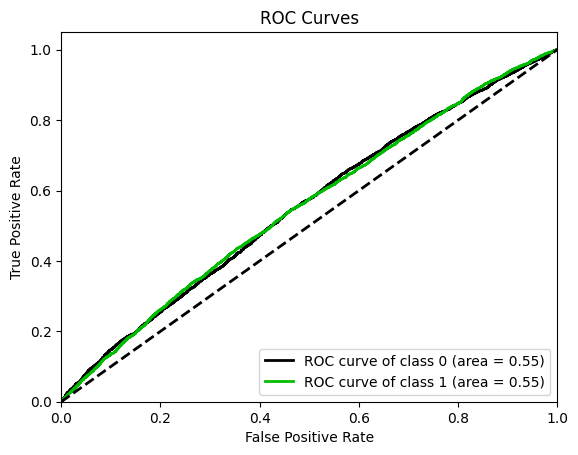

C:\Users\kevin\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


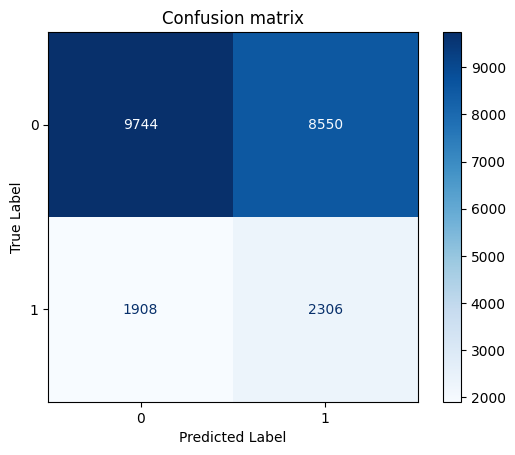

In [355]:
# Building Logistic Regression Classifier
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)
lr_pred_prob = lr_model.predict_proba(X_test)
classification_summary(lr_pred,lr_pred_prob, y_test, 'Logistic Regression (LR)')
plot_cmatrix(lr_model, X_test, y_test)

We can see that the Logistic regression performed poorly with a Recall about 53% and Precision of about 72% meaning that the False positives increased while the false negatives decreased which resulted an F1-score of 58%.  We can also see that the AUC-ROC is fairly small across the different classes which is another indication of poor model performance.

#### Decision Tree Classifier

The Decision Tree classifier is another classical classificaiton model which builds a decision tree where each node in the tree specifies a test on an attribute, and each branch descending from that node corresponds to one fo the possible values for that attribute.  In other words, it builds a bunch of rules, that categorizes each input data based on those rules.

<<<----------------------------------- Evaluating Decision Tree Classifier (DT) ----------------------------------->>>

Accuracy = 91.4%
F1 Score = 91.5%
Precision Score = 91.5%
Recall Score = 91.4%
AUC-ROC score = 86.5%

 Confusiton Matrix:
 [[17268  1026]
 [  900  3314]]

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.94      0.95     18294
           1       0.76      0.79      0.77      4214

    accuracy                           0.91     22508
   macro avg       0.86      0.87      0.86     22508
weighted avg       0.92      0.91      0.91     22508



C:\Users\kevin\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


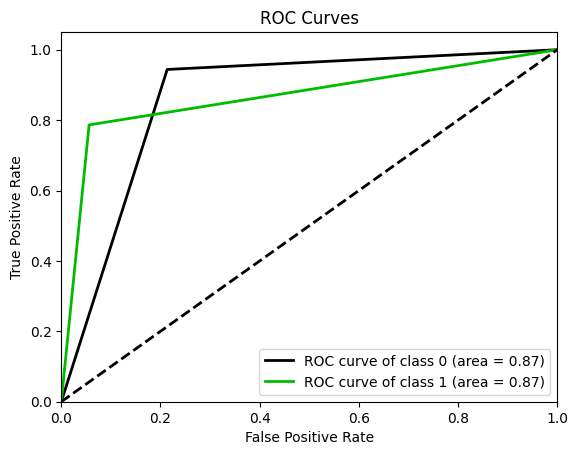

C:\Users\kevin\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


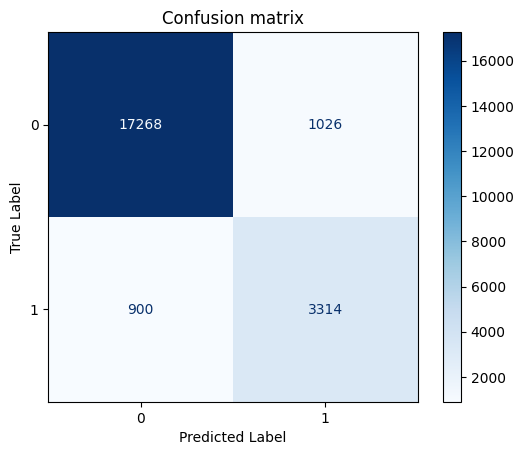

In [356]:
# Building Decision Tree Classifier
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
dt_pred = dt_model.predict(X_test)
dt_pred_prob = dt_model.predict_proba(X_test)
classification_summary(dt_pred,dt_pred_prob, y_test, 'Decision Tree Classifier (DT)')
plot_cmatrix(dt_model, X_test, y_test)

The decision tree classifier performed very well with a precision and recall of about 92%, and an F1-score of 92% as well. The AUC-ROC curve seems great as well, however the two ROC curve for each class is not consistent with one another so I would like to explore other models.

#### Random Forest Classifier

Let's explore the Random Forest Classifier.  This clasisfication algorithm is essentially a bunch of Decision trees, hence the Random Forrest. 

<<<----------------------------------- Evaluating Random Forest Classifier (RF) ----------------------------------->>>

Accuracy = 90.7%
F1 Score = 90.2%
Precision Score = 90.3%
Recall Score = 90.7%
AUC-ROC score = 92.80000000000001%

 Confusiton Matrix:
 [[17754   540]
 [ 1559  2655]]

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.97      0.94     18294
           1       0.83      0.63      0.72      4214

    accuracy                           0.91     22508
   macro avg       0.88      0.80      0.83     22508
weighted avg       0.90      0.91      0.90     22508



C:\Users\kevin\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


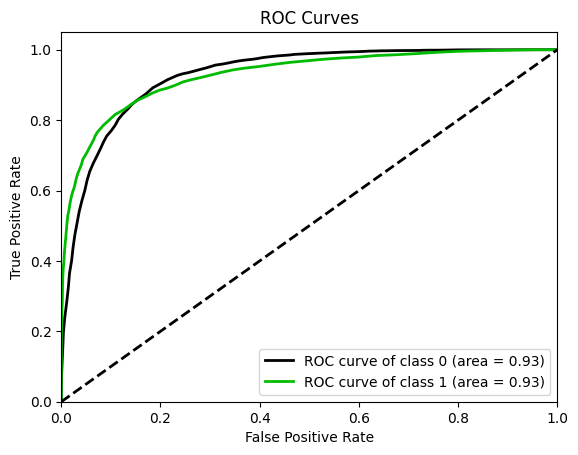

C:\Users\kevin\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


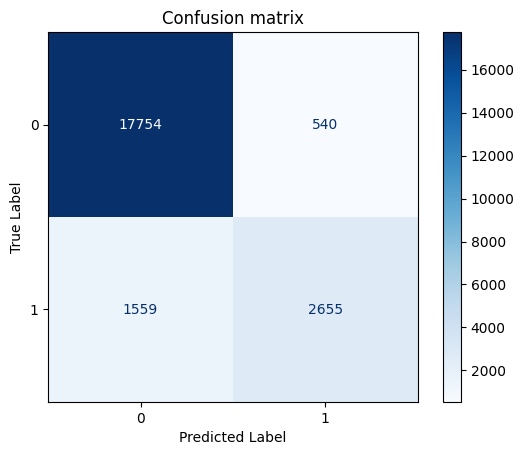

In [357]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train,y_train)
rf_pred = rf_model.predict(X_test)
rf_pred_prob = rf_model.predict_proba(X_test)
classification_summary(rf_pred, rf_pred_prob, y_test, 'Random Forest Classifier (RF)')
plot_cmatrix(rf_model, X_test, y_test)

Again the precision, recall and f1-score are about 90% which is great, and I also like how the ROC curve looks with both classes as it seems more consistent than the Decision Tree Classifier.  there is one more model I am curious to explore.

#### Naive Bayes Classifier
The Naive Bayes Classifier is a classical one, which like the Logistic regression, it is light weight and very simple.  One problem to consider though is that the algorithm assumes that each features are independent to one another, hence the naive.

<<<----------------------------------- Evaluating Naive Bayes Classifier (NB) ----------------------------------->>>

Accuracy = 57.099999999999994%
F1 Score = 61.7%
Precision Score = 70.89999999999999%
Recall Score = 57.099999999999994%
AUC-ROC score = 54.800000000000004%

 Confusiton Matrix:
 [[10962  7332]
 [ 2327  1887]]

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.60      0.69     18294
           1       0.20      0.45      0.28      4214

    accuracy                           0.57     22508
   macro avg       0.51      0.52      0.49     22508
weighted avg       0.71      0.57      0.62     22508



C:\Users\kevin\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


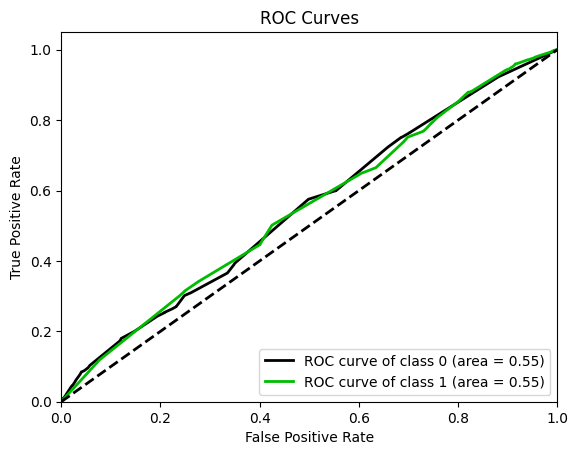

C:\Users\kevin\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


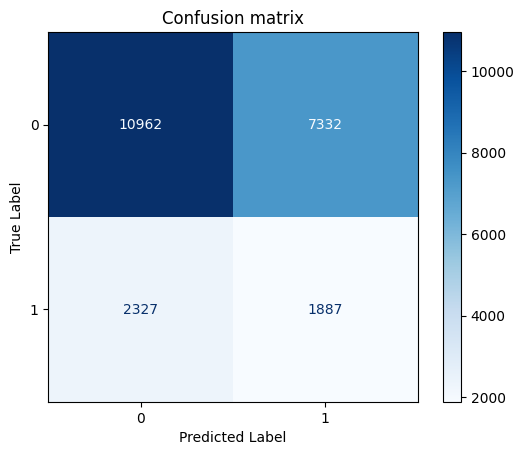

In [358]:
# Building Naive Bayes Classifier
nb_model = BernoulliNB()
nb_model.fit(X_train,y_train)
nb_pred = nb_model.predict(X_test)
nb_pred_prob = nb_model.predict_proba(X_test)
classification_summary(nb_pred,nb_pred_prob, y_test,'Naive Bayes Classifier (NB)')
plot_cmatrix(nb_model, X_test, y_test)

It's clear to see that this model is definitely a no go as it performed worst than the Logistic regression which is expected but at the same time, why not try it out?

### Model conclusion: Let's look at an overall summary of the different trained algorithms.

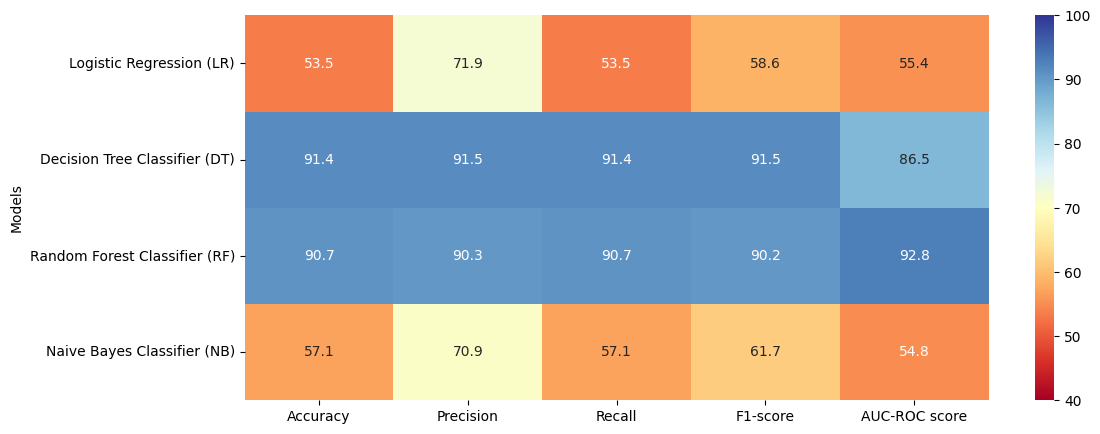

In [359]:
# Camparing all the models score
plt.figure(figsize=[12,5])
sns.heatmap(result_df, annot=True, vmin=40, vmax=100.0, cmap='RdYlBu', fmt='.1f')
plt.show()

Based on the performance of each model I've found that two top performing models are the Decision tree model and the Random forrest classifier model, and if I were to choose one model for this problem I'd go ahead and decide the Random Forrest Classifier.  Although the accuracy, recall, precision and F1-score are slightly better than the Random Forrets, the AUC-ROC score is what made my decision as I'd like the predicitons to be consistent amongst both classes.  However out of curiosity I want to try using `GridSearchCV` to find an optimal model for the two different classifiers.

### Using GridSearch

#### Random Forest with GridSearch

Choosing my Parameters for the gridsearch, then training the classifier with each possible parameters.

In [360]:
param_grid = { 
    'n_estimators': [100, 200],
    'max_features': ['sqrt', 'log2', None],
    'max_depth' : [3, 5, 7],
    'criterion' :['gini', 'log_loss']
}
rfc = RandomForestClassifier(random_state=42)
cv_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5, verbose=1)
cv_rfc.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


C:\Users\kevin\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
90 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\kevin\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\kevin\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_forest.py", line 450, in fit
    trees = Parallel(
  File "C:\Users\kevin\AppData\Roaming\Python\Python39\site-packages\joblib\parallel.py", line 1085, in __call__
    if self.dispatch_o

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'log_loss'],
                         'max_depth': [3, 5, 7],
                         'max_features': ['sqrt', 'log2', None],
                         'n_estimators': [100, 200]},
             verbose=1)

In [361]:
cv_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 7,
 'max_features': 'sqrt',
 'n_estimators': 200}

<<<----------------------------------- Evaluating Random Forest Clasifier (RF) with GridSearch ----------------------------------->>>

Accuracy = 66.9%
F1 Score = 70.3%
Precision Score = 77.7%
Recall Score = 66.9%
AUC-ROC score = 70.0%

 Confusiton Matrix:
 [[12469  5825]
 [ 1620  2594]]

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.68      0.77     18294
           1       0.31      0.62      0.41      4214

    accuracy                           0.67     22508
   macro avg       0.60      0.65      0.59     22508
weighted avg       0.78      0.67      0.70     22508



C:\Users\kevin\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


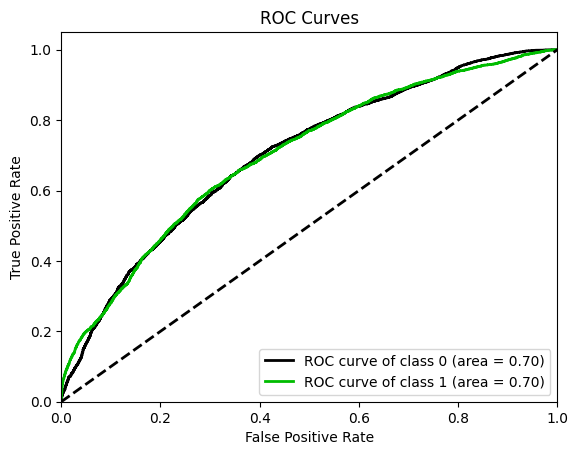

In [363]:
rf_opt = RandomForestClassifier(random_state=42, max_features='sqrt', n_estimators=200, max_depth=7, criterion='gini')
rf_opt.fit(X_train, y_train)
rcv_pred = rf_opt.predict(X_test)
rcv_pred_prob = rf_opt.predict_proba(X_test)
classification_summary(rcv_pred,rcv_pred_prob, y_test,'Random Forest Clasifier (RF) with GridSearch')

After performing gridsearch and obtaining best parameters I actually obtained worst performance.  Clearly the default settings gave me the best results.  Let's explore now the Decision tree.

#### Decision tree with GridSearch

Choosing my Parameters for the gridsearch, then training the classifier with each possible parameters.

In [364]:
param_grid = {'max_features': ['sqrt', 'log2', None],
              'ccp_alpha': [.03, .01, .001],
              'max_depth' : [3, 5, 7],
              'criterion' :['gini', 'log_loss']
             }
dtc = DecisionTreeClassifier(random_state=42)
cv_dtc = GridSearchCV(estimator=dtc, param_grid=param_grid, cv=5, verbose=1)
cv_dtc.fit(X_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


C:\Users\kevin\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
135 fits failed out of a total of 270.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
135 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\kevin\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\kevin\AppData\Roaming\Python\Python39\site-packages\sklearn\tree\_classes.py", line 937, in fit
    super().fit(
  File "C:\Users\kevin\AppData\Roaming\Python\Python39\site-packages\sklearn\tree\_classes.py", line 352, in fit
    criterion = CRITERIA_CLF

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'ccp_alpha': [0.03, 0.01, 0.001],
                         'criterion': ['gini', 'log_loss'],
                         'max_depth': [3, 5, 7],
                         'max_features': ['sqrt', 'log2', None]},
             verbose=1)

In [366]:
cv_dtc.best_params_

{'ccp_alpha': 0.001,
 'criterion': 'gini',
 'max_depth': 7,
 'max_features': 'sqrt'}

<<<----------------------------------- Evaluating Decision Tree Clasifier (RF) with GridSearch ----------------------------------->>>

Accuracy = 62.7%
F1 Score = 66.5%
Precision Score = 74.5%
Recall Score = 62.7%
AUC-ROC score = 61.7%

 Confusiton Matrix:
 [[11858  6436]
 [ 1969  2245]]

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.65      0.74     18294
           1       0.26      0.53      0.35      4214

    accuracy                           0.63     22508
   macro avg       0.56      0.59      0.54     22508
weighted avg       0.75      0.63      0.67     22508



C:\Users\kevin\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


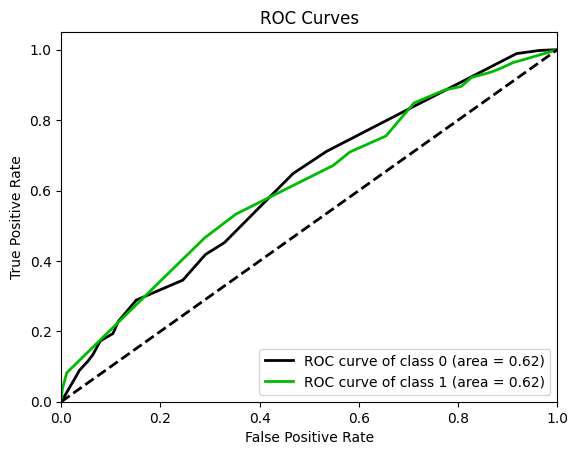

In [367]:
dt_opt = DecisionTreeClassifier(ccp_alpha=0.001, criterion='gini', max_depth=7, max_features='sqrt', random_state=42)
dt_opt.fit(X_train, y_train)
dcv_pred = dt_opt.predict(X_test)
dcv_pred_prob = dt_opt.predict_proba(X_test)
classification_summary(dcv_pred,dcv_pred_prob, y_test,'Decision Tree Clasifier (RF) with GridSearch')

Again the model performance degreaded, so I will keep my original models.  Below is a visualization of all trained models.

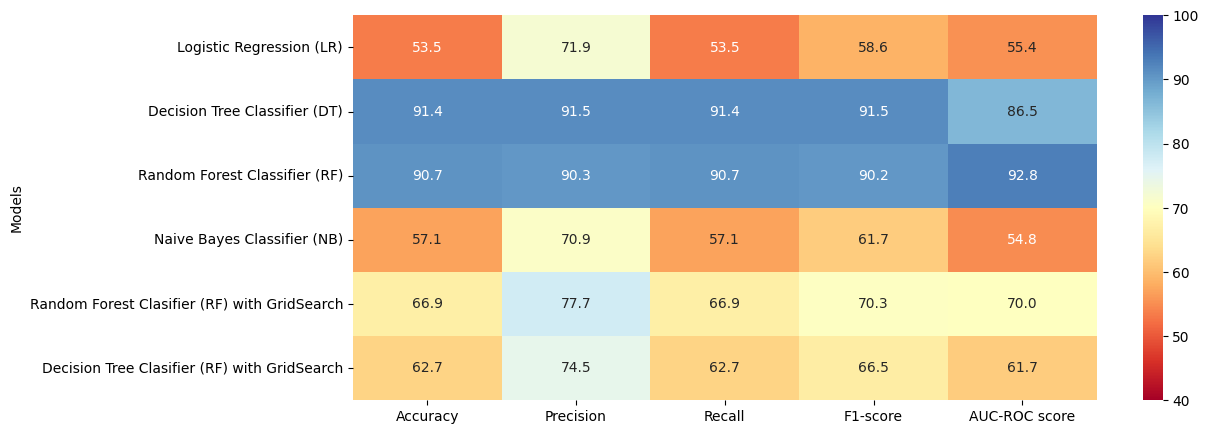

In [368]:
# Camparing all the models score
plt.figure(figsize=[12,5])
sns.heatmap(result_df, annot=True, vmin=40, vmax=100.0, cmap='RdYlBu', fmt='.1f')
plt.show()

### Exploring different variables with Random Forest

Let's use additional features and let's remove some other features into the dataset and observe it's performance

In [369]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68206 entries, 0 to 68205
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   sched_hour   68206 non-null  int64
 1   op_hour      68206 non-null  int64
 2   Ori-I        68206 non-null  int32
 3   Vlo-I        68206 non-null  int64
 4   Des-I        68206 non-null  int32
 5   Emp-I        68206 non-null  int32
 6   DIANOM       68206 non-null  int32
 7   TIPOVUELO    68206 non-null  int32
 8   OPERA        68206 non-null  int32
 9   SIGLAORI     68206 non-null  int32
 10  SIGLADES     68206 non-null  int32
 11  DIA          68206 non-null  int64
 12  MES          68206 non-null  int64
 13  period_day   68206 non-null  int32
 14  high_season  68206 non-null  int64
 15  delay_15     68206 non-null  int64
dtypes: int32(9), int64(7)
memory usage: 6.0 MB


Let's have three seperate set of features.  The following set of trraining features will be:

* `feature_v2`: Includes all synthetic data generated.
* `feature_v3`: Includes the entire dataset.
* `feature_v4`: Includes only what was originally given with the addition of the generated classification labels.

Then I want to split, and preprocess data all feature sets.

In [378]:
feature_v2 = features[['sched_hour', 'op_hour', 'period_day', 'high_season', 'delay_15']]
feature_v3 = features
feature_v4 = features.drop(['sched_hour', 'op_hour', 'period_day', 'high_season'], axis=1)

X_v2, y_v2 = feature_v2.drop(['delay_15'], axis=1), feature_v2['delay_15']
X_v3, y_v3 = feature_v3.drop(['delay_15'], axis=1), feature_v3['delay_15']
X_v4, y_v4 = feature_v4.drop(['delay_15'], axis=1), feature_v4['delay_15']

X2_train, X2_test, y2_train, y2_test = split_and_oversample(X_v2, y_v2)
X3_train, X3_test, y3_train, y3_test = split_and_oversample(X_v3, y_v3)
X4_train, X4_test, y4_train, y4_test = split_and_oversample(X_v4, y_v4)

#### Training with `feature_v2`

<<<----------------------------------- Evaluating Random Forest Classifier (RF) with feature_v2 dataset ----------------------------------->>>

Accuracy = 99.1%
F1 Score = 99.1%
Precision Score = 99.1%
Recall Score = 99.1%
AUC-ROC score = 99.9%

 Confusiton Matrix:
 [[18222    72]
 [  125  4089]]

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     18294
           1       0.98      0.97      0.98      4214

    accuracy                           0.99     22508
   macro avg       0.99      0.98      0.99     22508
weighted avg       0.99      0.99      0.99     22508



C:\Users\kevin\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


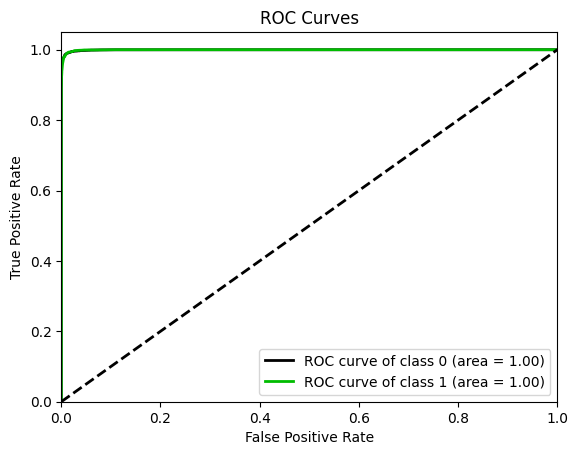

C:\Users\kevin\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


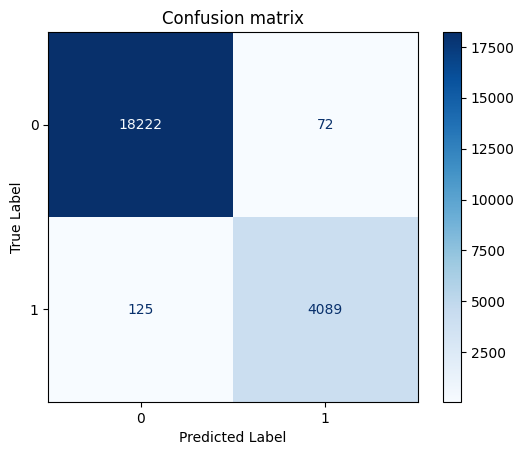

In [381]:
rf2_model = RandomForestClassifier(random_state=42)
rf2_model.fit(X2_train,y2_train)
rf2_pred = rf2_model.predict(X2_test)
rf2_pred_prob = rf2_model.predict_proba(X2_test)
classification_summary(rf2_pred, rf2_pred_prob, y2_test, 'Random Forest Classifier (RF) with feature_v2 dataset')
plot_cmatrix(rf2_model, X2_test, y2_test)

#### Training with `feature_v3`

<<<----------------------------------- Evaluating Random Forest Classifier (RF) with feature_v3 dataset ----------------------------------->>>

Accuracy = 90.0%
F1 Score = 89.4%
Precision Score = 89.5%
Recall Score = 90.0%
AUC-ROC score = 91.3%

 Confusiton Matrix:
 [[17691   603]
 [ 1655  2559]]

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.97      0.94     18294
           1       0.81      0.61      0.69      4214

    accuracy                           0.90     22508
   macro avg       0.86      0.79      0.82     22508
weighted avg       0.89      0.90      0.89     22508



C:\Users\kevin\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


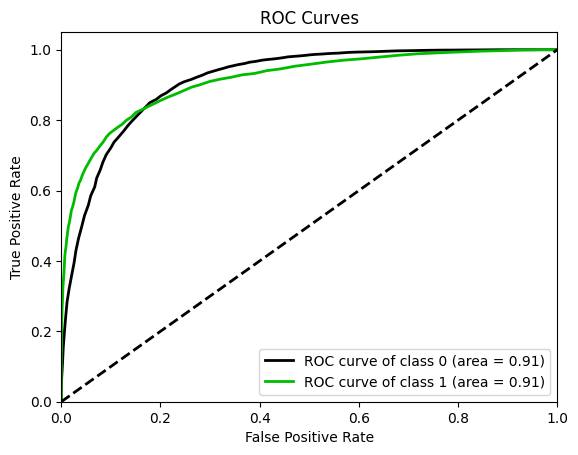

C:\Users\kevin\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


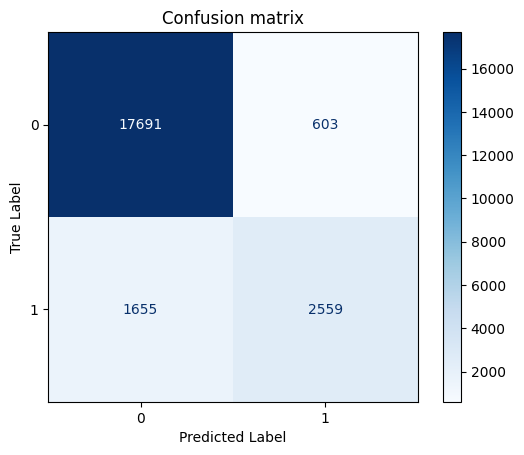

In [382]:
rf3_model = RandomForestClassifier(random_state=42)
rf3_model.fit(X3_train,y3_train)
rf3_pred = rf3_model.predict(X3_test)
rf3_pred_prob = rf3_model.predict_proba(X3_test)
classification_summary(rf3_pred, rf3_pred_prob, y3_test, 'Random Forest Classifier (RF) with feature_v3 dataset')
plot_cmatrix(rf3_model, X3_test, y3_test)

#### Training with `feature_v4`

<<<----------------------------------- Evaluating Random Forest Classifier (RF) ----------------------------------->>>

Accuracy = 73.5%
F1 Score = 74.6%
Precision Score = 76.0%
Recall Score = 73.5%
AUC-ROC score = 67.4%

 Confusiton Matrix:
 [[14766  3528]
 [ 2447  1767]]

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.81      0.83     18294
           1       0.33      0.42      0.37      4214

    accuracy                           0.73     22508
   macro avg       0.60      0.61      0.60     22508
weighted avg       0.76      0.73      0.75     22508



C:\Users\kevin\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


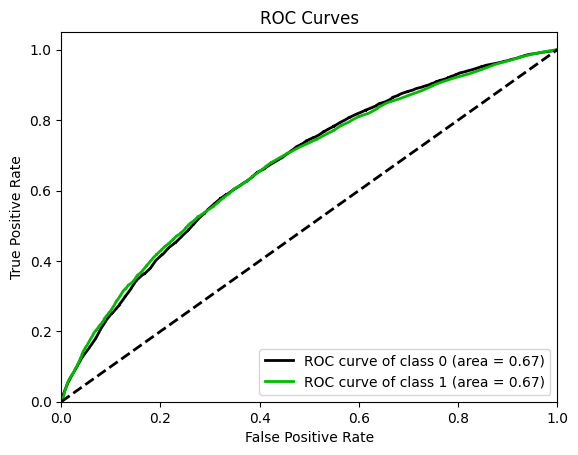

C:\Users\kevin\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


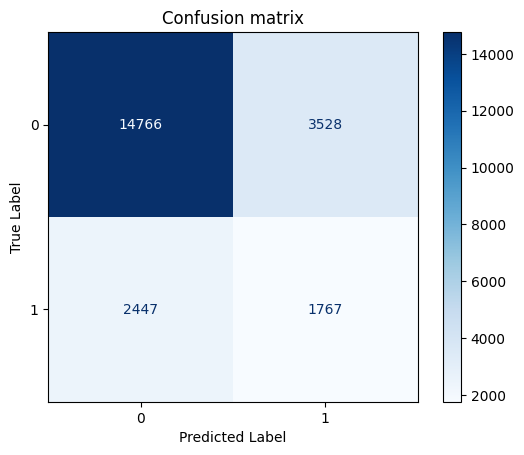

In [383]:
rf4_model = RandomForestClassifier(random_state=42)
rf4_model.fit(X4_train,y4_train)
rf4_pred = rf4_model.predict(X4_test)
rf4_pred_prob = rf4_model.predict_proba(X4_test)
classification_summary(rf4_pred, rf4_pred_prob, y4_test, 'Random Forest Classifier (RF)')
plot_cmatrix(rf4_model, X4_test, y4_test)

#### Summary with training on different datasets

I've found that when only using synthetic data, the random forest classifier achieves extremly high accuracy.  However, this can be of concern as it is purely processed data and doesn't include any other important information so the model may perform poorly in the real world.  In addition, adding additional variables such as airline code, destination code, etc. can be important factors for predicting delays.

When including all the data that was thought to be important performed well, and not much different than the first Random Forest classifier.  So it shows me that `OPERA`, `SIGLAORI`, `SIGLADES` data is not more relevant than just using the given code values.

When including the only the given data, it provided average performance which is not desired.  This comes to show that performing feature engineering is very important as it can increase the accuracy of the model.

## Summary

My assumptions, my findings and future work.

Assumptions:
1) The schduled flight number is the same as the operating flight number.
2) Name of city destination name has the same scheduled and operating codes.
3) Time difference with a negative value is considered as operating early and not considered late.

To summarize my findings:
1) The data was distributed based various city, airline, airport codes for the origin and destination.  The scheduled and flight operation date and time are two totally different data that's important because the scheduled time is not always the time in which the Flight will operate there will be delays and for various reasons.
2) Generating the synthetic features allowed me to gain a deeper understanding on the delay behaviour.  For example the days of the week, the Months play and day of month play an important factor on the flight delay.  same with the scheduled flight time, if it's during the afternoon there are more delays than at night time.
3) When training different classification algorithms, it was evident that using rule based decisions lead to imporoved performance which makes sense because depending on the day of the week, time of scheduled flight, and season of the year it can affect the flight operating time.
4) The model I'd choose for this type of problem is the Random Forest Classifier as it was able to obtain consistent results amongst both classes.  While training the different models I experiemnted with different types of datasets.  I initially started with the synthetic features only but obtained poor results, once I included the scheduled flight time it imporved my performance.  However after adding the destination code, the airline code and the operational flight time it improved improved my model to 90% accuracy.  
5) Using the default parameters for the given model performs better than doing a GridSearch.
6) Training on synthetic data only will perform exceptionally but despite the performance it is not recommended to use as it may perform poorly with raw data.  Assumtions made earlier were proven to be correct as destination code is enough to use for is respective names (airline/city/airport).  Training only on raw data will underperform as it cannot generalize the data well.

#### Future work

I would lke to do a few things in the future to improve the performance:

1) Get the estimated distance to travel between both the origin and destination as this will play a major role in flight delays because the airplane would need to refuel depending on the distance travelled.  The farther the distance the longer the refuel time.  I tried to implement this but lack computation.
2) Use a gradient boosting algorithm to possible impove the models performance, even if its by about 2%.
3) Try out more complex model if computation cost is not an issue.
